# 1. Load and imports

In [2]:
from eda import *
from pre_process import *
from topic_modeling import *
from percent import *
from itertools import chain
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel
from transformers import CamembertModel
from bertopic import BERTopic




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import plotly.express as px


In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
df = pd.read_csv('./../../Data/Dataframes/eulogies.csv')

In [5]:
df = df[((df['Annee']>1793) & (df['Annee']<1832))|(df['Auteur'] =='Condorcet')]

# 2. First axis : basic statistics

## Removing \n, \t, non-useful spaces

In [6]:
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

In [7]:
df.head()

Savant     Auteur  Annee  \
0       Fontaine  Condorcet   1771   
1       Perrault  Condorcet   1773   
2  de la Chambre  Condorcet   1773   
3       Frenicle  Condorcet   1773   
4          Boyle  Condorcet   1773   

                                               Eloge  
0  Alexis Fontaine naquit à Claveison en Dauphiné...  
1  Claude Perrault naquit à Paris, vers l’an 1613...  
2  [Condorcet avait mis, en marge de cette premiè...  
3  Nicolas Frenicle de Bessy, conseiller à la cou...  
4  On ignorait encore en Angleterre en 1666 les e...

## a. Number of eulogies

In [8]:
print('There are ' + str(df.shape[0]) + ' eulogies') 
print('There are ' + str(df[df['Annee']<1793].shape[0]) + ' eulogies before the French Revolution')
print('There are ' + str(df[df['Annee']>=1793].shape[0]) + ' eulogies after the French Revolution')

There are 144 eulogies
There are 78 eulogies before the French Revolution
There are 66 eulogies after the French Revolution


In [9]:
df['Auteur'].nunique()

12

## b. Number of eulogies per year

array([[<AxesSubplot:title={'center':'Annee'}>]], dtype=object)

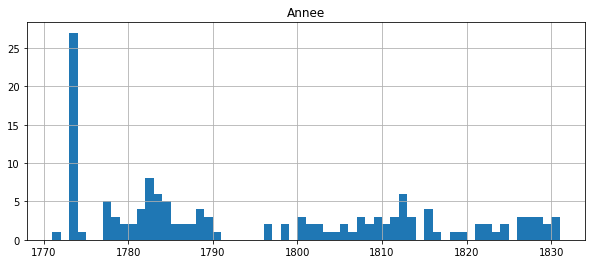

In [10]:
nbins = int(df['Annee'].max() - df['Annee'].min())
#nbins
df.hist('Annee', bins = nbins, figsize = (10,4))

In [11]:
df_help = df.groupby(['Annee'])['Savant'].count().reset_index().rename(columns = {'Savant' : 'count'})

df_pre = df_help[df_help['Annee']<=1793]
df_post = df_help[df_help['Annee']>1793]

In [12]:
from scipy.stats import ttest_ind

ttest_ind(df_pre['count'].array, df_post['count'].array)

Ttest_indResult(statistic=2.1043725964483397, pvalue=0.04096396730552059)

## b. Length of the eulogies

In [13]:
side_info(df)

df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('enfans', 'enfants').replace('instrumens', 'instruments')
                               .replace('talens', 'talents').replace('différens', 'différents').replace(
                               'monumens', 'monuments').replace('évènemens', 'évènements').replace('savans',
                                                                                                  'savants').
                               replace('documens', 'documents').replace('long-temps', 'longtemps'))

df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('†;', ';').replace('u?', 'ù'))

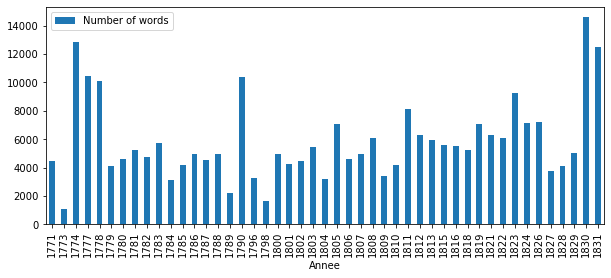

In [14]:
nbr_words_df = nbr_words(df, evol = True)

In [15]:
nbr_words_pre = nbr_words_df[nbr_words_df['Annee']<1793]
nbr_words_post = nbr_words_df[nbr_words_df['Annee']>=1793]

ttest_ind(nbr_words_pre['Number of words'].array, nbr_words_post['Number of words'].array)

Ttest_indResult(statistic=-0.20132239463632692, pvalue=0.8413537641053238)

## c. Average word length

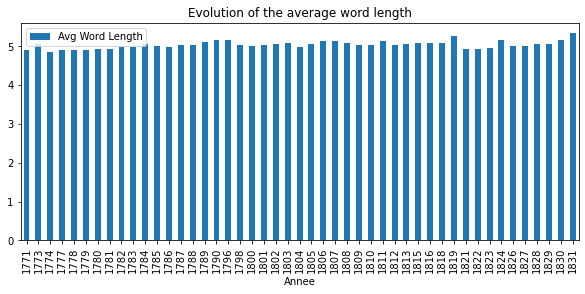

In [16]:
avg_words = avg_word_length(df, evol = True)

In [17]:
avg_words_pre = avg_words[avg_words['Annee']<=1793]
avg_words_post = avg_words[avg_words['Annee']>1793]

ttest_ind(avg_words_pre['Avg Word Length'].array, avg_words_post['Avg Word Length'].array)

Ttest_indResult(statistic=-3.525408520761012, pvalue=0.0009848974744641067)

## d. Average sentence length

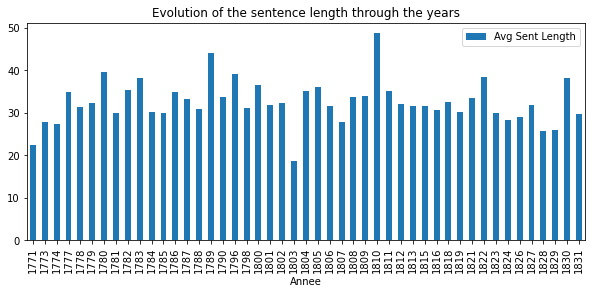

In [19]:
avg_sentence_df = avg_sentence(df, evol = True)

In [20]:
avg_sentence_pre = avg_sentence_df[avg_sentence_df['Annee']<1793]
avg_sentence_post = avg_sentence_df[avg_sentence_df['Annee']>=1793]

ttest_ind(avg_sentence_pre['Avg Sent Length'].array, avg_sentence_post['Avg Sent Length'].array)

Ttest_indResult(statistic=0.2340857959875094, pvalue=0.8159801235220829)

## e. Use of first person

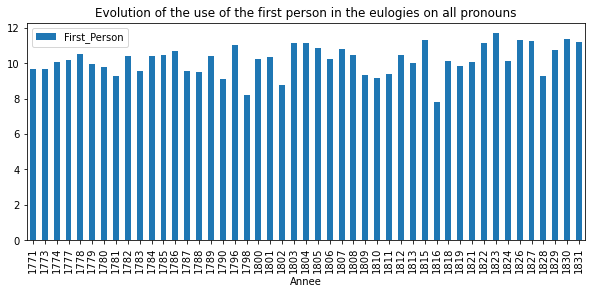

In [21]:
fst_person = first_person(df)

In [22]:
fst_person_pre = fst_person[fst_person['Annee']<1793]
fst_person_post = fst_person[fst_person['Annee']>=1793]

ttest_ind(fst_person_pre['First_Person'].array, fst_person_post['First_Person'].array)

Ttest_indResult(statistic=-1.3659039643825412, pvalue=0.17875724280276334)

## f. Use of modals

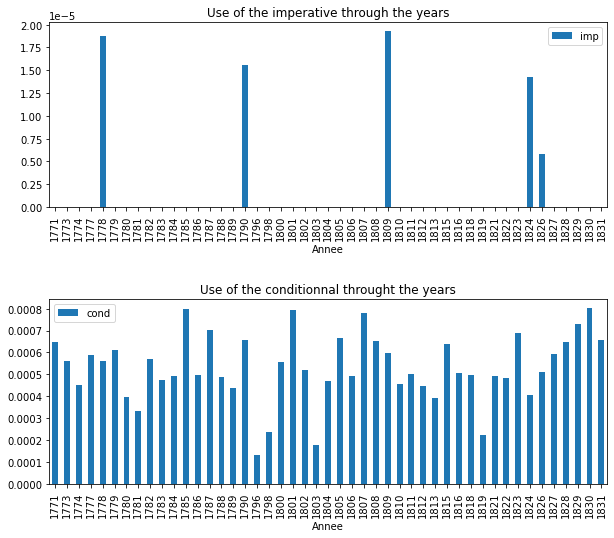

In [23]:
pci = cond_imperative(df)

In [29]:
c_adv = count_adverbs(df)

  0%|          | 0/144 [00:49<?, ?it/s]


In [137]:
c_adv.sort_values(by = 'Number', ascending = False, inplace = True)
c_adv.reset_index(inplace = True)
c_adv.pop('index')
c_adv

Adverb  Number
0               plus    5933
1                 ne    5339
2                pas    3139
3                  n    2310
4             encore    1404
..               ...     ...
477    manifestement       1
478  mathmatiquement       1
479          mauvais       1
480     mcaniquement       1
481     vulgairement       1

[482 rows x 2 columns]

In [138]:
c_adv_pc = c_adv[c_adv['Number']>=5]
c_adv_pc['Categorie'] = 'default value'

- si loc 5
- que loc 52
- qu loc 83
- rien
- voilà 95
- voici 150
- minnement 183
- avec 196
- vice 220


In [139]:
c_adv_pc_old = pd.read_csv('./../../Data/Results/Adverbs.csv')

In [140]:
c_adv_pc['Assertivité'] = 'default value'

In [141]:
c_adv_tot = pd.merge(c_adv_pc, c_adv_pc_old, on = 'Adverb', how = 'left')

In [149]:
c_adv_tot.head()

Adverb  Number               Categorie    Assertivité    Temporalité
0    plus    5933                quantité  default value  default value
1      ne    5339                négation  default value  default value
2     pas    3139                négation  default value  default value
3       n    2310                négation  default value  default value
4  encore    1404  temps_quantité_logique  default value  default value

In [146]:
c_adv_tot.pop('Number_y')

0      5933
1      5339
2      3139
3      2310
4      1404
       ... 
252       5
253       5
254       5
255       5
256       5
Name: Number_y, Length: 257, dtype: int64

In [148]:
c_adv_tot.rename(columns = {'Number_x' : 'Number', 'Assertivité_y' : 'Assertivité', 'Categorie_y' : 'Categorie'},
                inplace = True)

In [175]:
c_adv_tot['Temporalité'] = 'default value'
c_adv_tot['Experience'] = 'default value'

In [150]:
c_adv_tot.to_csv('./../../Data/Results/Adverbs.csv', index=False)

In [188]:
modals = [x for x, y in zip(c_adv_pc['Adverb'], c_adv_pc['Categorie']) if 'modal' in y]
modals

['naturellement',
 'aisment',
 'malheureusement',
 'certainement',
 'apparemment',
 'clairement',
 'communment',
 'spcialement',
 'minemment',
 'vraisemblablement',
 'personnellement',
 'incomparablement']

In [186]:
df['Modals_adv'] =df['Eloge'].apply(lambda x : [word for word in x.split() if word in modals])

In [190]:
modals = df.groupby(['Annee'])['Modals_adv'].apply(list).reset_index()
modals.head()

Annee                                         Modals_adv
0   1741                                  [[naturellement]]
1   1742                          [[], [], [naturellement]]
2   1743  [[vraisemblablement], [vraisemblablement], [na...
3   1744                                               [[]]
4   1746                                               [[]]

In [192]:
modals['Modals_adv'] = modals['Modals_adv'].apply(lambda x : sum([len(ls) for ls in x]))


<AxesSubplot:xlabel='Annee'>

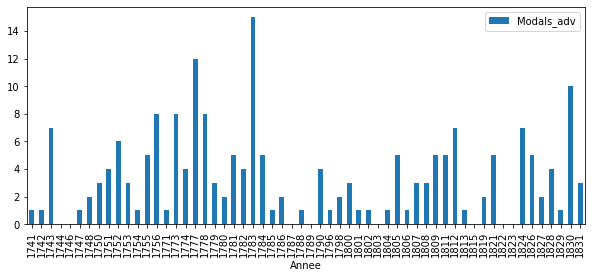

In [197]:
modals.plot('Annee', 'Modals_adv', kind = 'bar', figsize = (10,4))

## g. Use of past tenses

100%|███████████████████████████████████████| 144/144 [00:00<00:00, 3082.44it/s]


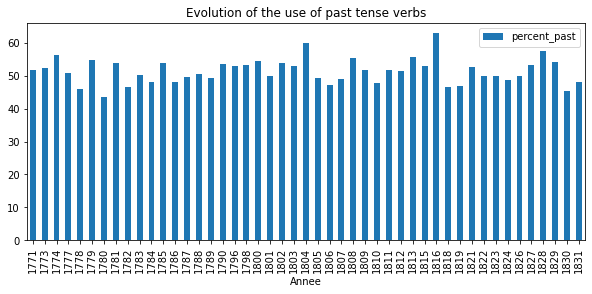

In [22]:
past_tense = past_tense(df)

In [23]:
past_tense_pre = past_tense[past_tense['Annee']<1793]
past_tense_post = past_tense[past_tense['Annee']>=1793]

ttest_ind(past_tense_pre['percent_past'].array, past_tense_post['percent_past'].array)

Ttest_indResult(statistic=-1.1382716668903345, pvalue=0.2610310346186218)

Reject Null Hypothesis the means are statistically different

## h. Starts with a statement on the birth

In [24]:
naissance(df)

In [25]:
df[df['naissance'] == False].shape[0]

51

In [26]:
df[(df['naissance'] == False)&(df['Annee']<1793)].shape[0]

16

In [27]:
df[(df['naissance'] == False)&(df['Annee']>=1793)].shape[0]

35

## i. Use of Proper Names


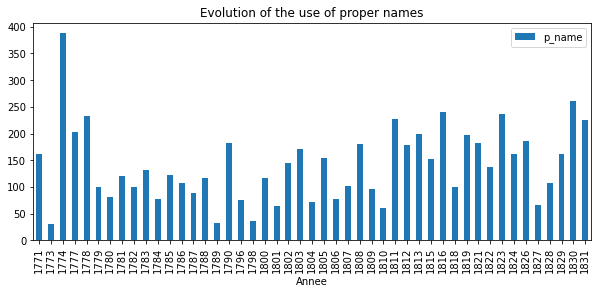

In [28]:
p_n = proper_name(df)

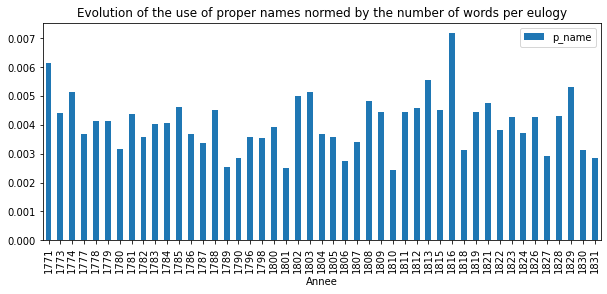

In [29]:
p_norm = proper_name(df, norm = True)

# 3. Second axis : Topic modeling

## Divide the dataframe into sentences

In [24]:
#https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

#Replace M. for Monsieur with M for the splitting
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('M.', 'M'))
lens = df['Eloge'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
sent = pd.DataFrame({'Savant': np.repeat(df['Savant'], lens),
                    'Auteur': np.repeat(df['Auteur'], lens),
                     'Annee' : np.repeat(df['Annee'], lens),
                    'Eloge': chainer(df['Eloge'])})

sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

In [25]:
# convert to list
sent = df.copy()

#sent['Eloge'] = sent['Eloge'].str.replace(';', '.')
sent['Eloge'] = sent['Eloge'].str.replace('!', '.')
sent['Eloge'] = sent['Eloge'].str.replace('?', '.')
sent['Eloge'] = sent['Eloge'].str.split('.')

# convert list of pd.Series then stack it


In [26]:
sent = (sent
 .set_index(['Savant','Auteur','Annee'])['Eloge']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_3', axis=1)
 .rename(columns={0:'Eloge'}))

In [27]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet   1771   
1  Fontaine  Condorcet   1771   
2  Fontaine  Condorcet   1771   
3  Fontaine  Condorcet   1771   
4  Fontaine  Condorcet   1771   

                                               Eloge  
0  Alexis Fontaine naquit à Claveison en Dauphiné...  
1   Il avait environ vingt ans lorsque son père m...  
2   Ses parents auraient voulu qu’il suivit les é...  
3   Né avec cette rigueur d’esprit que les démons...  
4   Tourmenté par les sollicitations de ses paren...

In [28]:
sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

In [29]:
sent.shape

(17784, 4)

In [30]:
sent['Wrong'] = sent['Eloge'].apply(lambda x : x.count('?'))

In [31]:
sent['Wrong'].sum()

0

In [32]:
#Preprocessing the sentences
rmv_sw(sent, name_col = 'Eloge')
rmv_punkt(sent)
lemmatize(sent, 'no_sw_no_punkt', 'tags')
rmv_digit(sent)

In [33]:
#Only keeping nouns and verbs to avoid noise
nouns_verbs(sent, 'Eloge_lem')

In [34]:
sent.reset_index(inplace = True)
sent.drop('index', axis = 1, inplace = True)
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet   1771   
1  Fontaine  Condorcet   1771   
2  Fontaine  Condorcet   1771   
3  Fontaine  Condorcet   1771   
4  Fontaine  Condorcet   1771   

                                               Eloge  Wrong  \
0  Alexis Fontaine naquit à Claveison en Dauphiné...      0   
1   Il avait environ vingt ans lorsque son père m...      0   
2   Ses parents auraient voulu qu’il suivit les é...      0   
3   Né avec cette rigueur d’esprit que les démons...      0   
4   Tourmenté par les sollicitations de ses paren...      0   

                                               no_sw  \
0  Alexis Fontaine naquit Claveison Dauphiné, l’a...   
1                                    ans père mourut   
2  Ses parents voulu qu’il suivit études droit, n...   
3  rigueur d’esprit démonstrations satisfaire, do...   
4  Tourmenté sollicitations parents, l’activité g...   

                                      no_sw_no_punkt  \
0  Alexis Fontaine naquit Claveison Dauphiné  l a...   
1                                    ans père mourut   
2  Ses parents voulu qu il suivit études droit  n...   
3  rigueur d esprit démonstrations satisfaire  do...   
4  Tourmenté sollicitations parents  l activité g...   

                                                tags  \
0  [(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...   
1  [(ans, NOM, an), (père, NOM, père), (mourut, V...   
2  [(Ses, DET:POS, son), (parents, NOM, parents),...   
3  [(rigueur, NOM, rigueur), (d, VER:futu, d), (e...   
4  [(Tourmenté, VER:pper, tourmenter), (sollicita...   

                                           Eloge_lem  \
0  Alexis Fontaine naître Claveison Dauphiné l an...   
1                                     an père mourir   
2  son parents vouloir qu il suivre étude droit n...   
3  rigueur d esprit démonstration satisfaire donn...   
4  tourmenter sollicitation parent l activité gén...   

                                                 n_v  
0                                naître l année card  
1                                     an père mourir  
2  vouloir suivre étude exercer charge styler com...  
3  rigueur d esprit démonstration satisfaire donn...  
4  tourmenter sollicitation l activité génie prov...

In [35]:
#Removing stop words and really short words that might still be here
sent['n_v'] = sent['n_v'].apply(lambda x : ' '.join([elem for elem in x.split() if (elem not in fr_stop and 
                                                                                    len(elem)>2)]))

## Embedding models

I tested different embedding models and chose to stay with the sentence transformer as it was the one working  the best

In [36]:
np.random.seed(123)

model_sent = SentenceTransformer('distiluse-base-multilingual-cased-v1')

#modelname = 'flaubert/flaubert_base_cased' 
#flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)

#camembert = CamembertModel.from_pretrained('camembert/camembert-base-wikipedia-4gb')

## Bertopic

In [37]:
#Loading Bertopic with embedding model chosen and nr_topics to auto so that topic with more than 0.9 similarity are
#merged
model = BERTopic(embedding_model = model_sent, min_topic_size = 30,
                 nr_topics='auto',calculate_probabilities = True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [38]:
topics, probabilities = model.fit_transform(sent.n_v)

In [39]:
with open("./../../Data/Results/topics", "wb") as fp:   #Pickling
    pickle.dump(topics, fp)
 
#with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
#    topics = pickle.load(fp)


In [40]:
with open("./../../Data/Results/probabilities", "wb") as fp:   #Pickling
    pickle.dump(probabilities, fp)
    
    
#with open("./../../Data/Results/probabilities", "rb") as fp:   # Unpickling
#    probabilities = pickle.load(fp)

In [41]:
df_rep = pd.DataFrame({'Topic': topics, 'Document': sent.Eloge_lem, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})

df_rep['Prob'] = df_rep.apply(lambda row : probabilities[row.name][row['Topic']], axis = 1)

In [42]:
pd.set_option('display.max_rows', 200)

In [43]:
#df_info.to_csv('./../../Data/Results/topic_modeling_sentence.csv')
#df_info = pd.read_csv('./../../Data/Results/topic_modeling_sentence.csv', index_col = 0)
#df_info.head(1)

In [44]:
model.save('./../../Data/Results/bert_model')
#model = BERTopic.load('./../../Data/Results/bert_model')

/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [45]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet   1771   
1  Fontaine  Condorcet   1771   
2  Fontaine  Condorcet   1771   
3  Fontaine  Condorcet   1771   
4  Fontaine  Condorcet   1771   

                                               Eloge  Wrong  \
0  Alexis Fontaine naquit à Claveison en Dauphiné...      0   
1   Il avait environ vingt ans lorsque son père m...      0   
2   Ses parents auraient voulu qu’il suivit les é...      0   
3   Né avec cette rigueur d’esprit que les démons...      0   
4   Tourmenté par les sollicitations de ses paren...      0   

                                               no_sw  \
0  Alexis Fontaine naquit Claveison Dauphiné, l’a...   
1                                    ans père mourut   
2  Ses parents voulu qu’il suivit études droit, n...   
3  rigueur d’esprit démonstrations satisfaire, do...   
4  Tourmenté sollicitations parents, l’activité g...   

                                      no_sw_no_punkt  \
0  Alexis Fontaine naquit Claveison Dauphiné  l a...   
1                                    ans père mourut   
2  Ses parents voulu qu il suivit études droit  n...   
3  rigueur d esprit démonstrations satisfaire  do...   
4  Tourmenté sollicitations parents  l activité g...   

                                                tags  \
0  [(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...   
1  [(ans, NOM, an), (père, NOM, père), (mourut, V...   
2  [(Ses, DET:POS, son), (parents, NOM, parents),...   
3  [(rigueur, NOM, rigueur), (d, VER:futu, d), (e...   
4  [(Tourmenté, VER:pper, tourmenter), (sollicita...   

                                           Eloge_lem  \
0  Alexis Fontaine naître Claveison Dauphiné l an...   
1                                     an père mourir   
2  son parents vouloir qu il suivre étude droit n...   
3  rigueur d esprit démonstration satisfaire donn...   
4  tourmenter sollicitation parent l activité gén...   

                                                 n_v  
0                                  naître année card  
1                                        père mourir  
2  vouloir étude exercer charge styler commentate...  
3  rigueur esprit démonstration satisfaire donner...  
4  tourmenter sollicitation activité génie provin...

In [54]:
_ = sent_rep(0, df_rep)

 Le jour même, il appela l'auteur de la lettre, et lui dit, ce sont ses propres paroles : Monsieur vous voyez que je fais assez peu de cas des recommandations ; vous n'en aviez pas besoin


 On chercherait vainement à éluder la difficulté, en décidant qu’alors l’intérêt général doit l’emporter ; ce patriotisme exagéré n’est qu’une illusion dangereuse, capable d’entraîner à des injustices, et même à des crimes, les hommes ignorants et passionnés


 Avec une telle intention, il ne choisissait pas ses auditeurs : ceux que le hasard lui offrait, semblaient devoir mieux représenter le public, dont il voulait essayer sur eux la manière de sentir ; il ne se bornait pas à recevoir leurs avis, ou plutôt leurs éloges, souvent il leur demandait quel sens ils attachaient à une phrase, quelle impression ils avaient éprouvée ; et s’ils n’avaient pas saisi son idée, s’il avait manqué l’effet qu’il voulait produire, il en concluait que cette partie de son ouvrage manquait de netteté, de mesure ou de f

In [47]:
df_info = model.get_topic_info()
df_info

Topic  Count                                         Name
0      -1   9166                -1_homme_faire_pouvoir_donner
1       0   2625                     0_science_fil_père_homme
2       1    929                  1_card_naître_année_société
3       2    669               2_planter_plante_espèce_jardin
4       3    521                          3_air_rayon_sel_eau
5       4    396      4_astronome_astronomie_soleil_mouvement
6       5    395           5_médecin_maladie_médeciner_remède
7       6    324              6_pierre_montagne_rocher_volcan
8       7    244        7_chimie_chimiste_substance_chimiquer
9       8    221                       8_prince_roi_duc_condé
10      9    218          9_mémoire_souvenir_imprimer_oublier
11     10    188       10_géomètre_géométrie_géographe_calcul
12     11    173               11_génie_homme_force_ingénieur
13     12    150            12_professeur_école_élève_collège
14     13    149         13_travail_carrière_temps_travailler
15     14    147     14_religion_pape_protester_christianisme
16     15    118  15_philosophie_philosopher_philosophe_faire
17     16    112     16_expérience_mariotte_confirmer_répéter
18     17    111      17_ministre_gouvernement_ministère_voir
19     18     85       18_théorie_expérience_principe_déduire
20     19     81           19_nature_naturaliste_homme_raison
21     20     69               20_jeunesse_enfance_âge_enfant
22     21     68             21_vaisseau_navire_capitaine_mer
23     22     68  22_anatomie_anatomiste_comparer_description
24     23     55    23_langue_traduction_langage_dictionnaire
25     24     55                24_force_forces_forcer_esprit
27     25     54    25_horloge_horlogerie_perfection_penduler
26     26     54        26_histoire_écrire_historien_document
28     27     52                 27_amitié_ami_sentiment_unir
29     28     47           28_vérité_général_marque_proscrire
30     29     44          29_révolution_devoir_opérer_malheur
31     30     43             30_île_bougainville_visiter_côte
32     31     40      31_matériau_matériaux_rassembler_papier
33     32     40             32_famille_milieu_origine_chérir
34     33     38              33_guerre_soldat_ambassade_paix
35     34     35                 34_impôt_payer_peuple_denrée

## Hierarchical clustering

In [55]:
#0, 1,
#Manually creating topics
topic_discipline = [4,5,7,10,15,19,22,25,26]
topic_element = [2,3,6,16,18,31]
topic_vie = [0,1,12, 13, 20, 27, 32]
topic_politique = [8,17,29,33,34]
#topic_ouvrage = []
topic_voyage = [21, 30]
topic_religion = [14]
topic_qualite = [11,24,28]
topic_memoire = [9,23]

In [56]:
topic_dict = {'discipline' : topic_discipline, 'element' : topic_element, 'vie' : topic_vie, 
             'politique' : topic_politique,  'religion' : topic_religion, 
              'voyage' : topic_voyage, 'qualite' : topic_qualite, 'memoire' : topic_memoire}
#'ouvrage' : topic_ouvrage,

In [57]:
#higher topics

topic_science = topic_discipline + topic_element
topic_personne = topic_vie + topic_qualite 
topic_posterite = topic_memoire #+ topic_ouvrage
topic_societe = topic_religion + topic_politique

In [58]:
high_dict = {'science' : topic_science, 'personne' : topic_personne, 'posterite' : topic_posterite,
                                                                          'societe' : topic_societe,
            'voyage' : topic_voyage}

In [59]:
model.visualize_hierarchy()

In [280]:
import kaleido

df_plot = df_info.copy()
df_plot['High_High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, high_dict)[1])
df_plot['High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, topic_dict)[1])
df_plot = df_plot[df_plot['High_Topic']!='outlier']
df_plot['Phrase'] = df_plot['Topic'].apply(lambda x : sent_rep(x, df_rep, print_=False).Eloge.tolist())
df_plot = df_plot.explode('Phrase')

fig = px.icicle(df_plot, path=[px.Constant("all"), 'High_High_Topic', 'High_Topic', 'Name', 'Phrase'])
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
fig.write_html('./../../Data/Results/hierarchy.html')

In [170]:
df_plot.head()

Topic  Count                                     Name High_High_Topic  \
1      0   2625                 0_science_fil_père_homme        personne   
2      1    929              1_card_naître_année_société        personne   
3      2    669           2_planter_plante_espèce_jardin         science   
4      3    521                      3_air_rayon_sel_eau         science   
5      4    396  4_astronome_astronomie_soleil_mouvement         science   

   High_Topic                                             Phrase  
1         vie  [ Alors, autour de lui,  Il détestait surtout ...  
2         vie  [ Il mourut le 15 octobre 1785, âgé d’environ ...  
3     element  [ Trop longtemps les botanistes voyageurs n'av...  
4     element  [ MM de Fourcroy et Vauquelin ont prouvé qu'il...  
5  discipline  [  Son frère aîné, mort peu de temps avant lui...

## Topics over time

In [61]:
#with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
#    topics = pickle.load(fp)
    

df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})
df_top.head()

Topic                                           Document  \
0      1                                  naître année card   
1     -1                                        père mourir   
2     -1  vouloir étude exercer charge styler commentate...   
3     -1  rigueur esprit démonstration satisfaire donner...   
4     -1  tourmenter sollicitation activité génie provin...   

                                               Eloge  Annee    Savant  \
0  Alexis Fontaine naquit à Claveison en Dauphiné...   1771  Fontaine   
1   Il avait environ vingt ans lorsque son père m...   1771  Fontaine   
2   Ses parents auraient voulu qu’il suivit les é...   1771  Fontaine   
3   Né avec cette rigueur d’esprit que les démons...   1771  Fontaine   
4   Tourmenté par les sollicitations de ses paren...   1771  Fontaine   

      Auteur  
0  Condorcet  
1  Condorcet  
2  Condorcet  
3  Condorcet  
4  Condorcet

In [62]:
df_top[df_top['Topic']==12]

Topic                                           Document  \
550       12  profiter occuper manuscrit disciple volter soi...   
629       12             collège chaire fonder revenir concours   
630       12  professeur proposer problème quelqu résoudre p...   
1087      12                             pension passer collège   
1108      12  revenir siège innocence mœurs effort camarader...   
2256      12      talent ouvrage éducation développer éducation   
2449      12  imaginer dresser journal détailler maladie env...   
2504      12                       élever œil ouvrage éducation   
3537      12  talent enseigner développer temps faciliter ap...   
3706      12              éducation pouvoir augmenter faiblesse   
3811      12  paraître devoir rester Courtanvaux éducation n...   
3884      12               quitter projet instruire leçon homme   
4024      12                aider projet homme talent éducation   
4397      12                         ami choisir sortir collège   
5208      12  cours|cour cour Bézout adopter nombre école ma...   
5209      12  examen élever école voyager examen obliger dis...   
5228      12  envoyer âge séminaire passer année mériter con...   
5697      12                   honneur élire recteur université   
5704      12                      roi désirer attacher académie   
5927      12  élève soumettre examen exiger admettre connais...   
6534      12  cabinet commencer éducation mettre perfection ...   
6976      12  gagner ouvrier philosopher américain donner fa...   
7261      12  parens envoyer heure collège établir chanoine ...   
7425      12  hommage éclater consoler lettre perte avoyer f...   
7555      12  admettre faire connaître aimer étude devenir p...   
7729      12  élève vouloir étendre cadre remplir compilatio...   
7826      12                             collège espérer public   
8128      12                   âge continuer collège université   
8131      12  fier subir peine croire aller demeurer collège...   
8133      12  professeur permettre jour jeter livre tête élè...   
8152      12  élève lorsqu nommer professeur lorsqu devenir ...   
8153      12  vivacité esprit rapidité abondance élocution q...   
8417      12       circonstance professeur muséum hésiter choix   
8419      12                                  nommer professeur   
8482      12  avantage appartenir éducation paraître donner ...   
8489      12                          condition rang professeur   
8585      12  mémoire intimer confier aujourd ouvrir réserve...   
8586      12  offrir faire nommer élève valoir argent vouloi...   
8588      12  asseoir professeur avenir charger justifier ca...   
8589      12          enseignement cuvier départ effort relever   
8638      12                            raisonneur élever école   
8652      12  vocation penser joie orgueil vie priser titre ...   
8656      12  curieux presser besoin communiquer réfléchir e...   
8661      12  heure pouvoir continuer instruire livre prêter...   
8666      12  district ville envoyer élève école santé venir...   
8768      12                 population cesser renouveler école   
8774      12  revêtir robe toquer professeur placer fusilier...   
9099      12                grammaire production employer école   
9175      12      professer abandonner devenir unitaire appeler   
9301      12          montrer importance place occuper institut   
9368      12  manière pouvoir paraître sein institut applaud...   
9507      12             commissaire académie trouver exécution   
9609      12  devenir élève ami Nollet placer professeur col...   
9658      12                 citer Sgravesende Nollet enseigner   
9818      12  doctriner admettre enseigner professeur distin...   
9850      12  faire suppléant collège adjoindre école contri...   
9873      12  quitter degré sécheresse styler caractère écol...   
9914      12  falloir ministre porter intérêt école user sor...   
9929      12   classe école remplir chaire diriger jar

In [63]:
df_top['Words'] = df_top['Topic'].apply(lambda x : df_info[df_info['Topic']==x].reset_index()['Name'][0])
df_top['Words'] = df_top['Words'].apply(lambda x : ', '.join(x.split('_')[1:]))

In [64]:
#Normalize by number of sentences

topics_over_time_norm = df_top.groupby(['Annee', 'Topic', 'Words'])['Eloge'].count().reset_index()
topics_over_time_norm.rename(columns = {'Annee' : 'Timestamp', 'Eloge' : 'Frequency'}, inplace = True)

topics_over_time_norm.head()

Timestamp  Topic                                 Words  Frequency
0       1771     -1         homme, faire, pouvoir, donner         61
1       1771      0             science, fil, père, homme         31
2       1771      1          card, naître, année, société          7
3       1771      2       planter, plante, espèce, jardin          3
4       1771      9  mémoire, souvenir, imprimer, oublier          2

In [65]:
df_by_year = df.groupby('Annee')['Eloge'].count().reset_index()
sent_by_year = sent.groupby('Annee')['Eloge'].count().reset_index()

In [66]:
sent_topic_time = topics_over_time_norm.copy()

topics_over_time_norm = pd.merge(topics_over_time_norm, df_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')
topics_over_time_norm.head()

Timestamp  Topic                                 Words  Frequency  Annee  \
0       1771     -1         homme, faire, pouvoir, donner         61   1771   
1       1771      0             science, fil, père, homme         31   1771   
2       1771      1          card, naître, année, société          7   1771   
3       1771      2       planter, plante, espèce, jardin          3   1771   
4       1771      9  mémoire, souvenir, imprimer, oublier          2   1771   

   Eloge  
0      1  
1      1  
2      1  
3      1  
4      1

In [67]:
sent_topic_time = pd.merge(sent_topic_time, sent_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')

In [68]:
topics_over_time_norm['Frequency'] = topics_over_time_norm.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
topics_over_time_norm.pop('Eloge')
topics_over_time_norm.pop('Annee')

sent_topic_time['Frequency'] = sent_topic_time.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
sent_topic_time.pop('Eloge')
sent_topic_time.pop('Annee')

0       1771
1       1771
2       1771
3       1771
4       1771
        ... 
1102    1831
1103    1831
1104    1831
1105    1831
1106    1831
Name: Annee, Length: 1107, dtype: int64

In [69]:
bins = sent.Annee.unique().shape[0]
topics_over_time = model.topics_over_time(sent.n_v, topics, sent.Annee, nr_bins=bins)
topics_over_time

Topic                                              Words  Frequency  \
0       -1          homme, gloire, donner, vanité, méchanceté         61   
1        0   équation, méthode, calcul, solution, intégration         31   
2        1     card, imprimer, cuiseaux, seigneurie, préfacer          7   
3        2     légataire, anel, fermier, aversion, obligation          3   
4        9            recueil, mémoire, délier, voir, morceau          2   
..     ...                                                ...        ...   
935     28    complétemeut, vérité, réduction, phase, général          1   
936     29  révolution, prospérité, falloir, continuer, en...          1   
937     30     islande, cristaux, apporter, recueillir, terme          1   
938     32         famille, volter, heure, étonner, remarquer          1   
939     33            soldat, guerre, javelot, brèche, légion          3   

     Timestamp  
0     1770.940  
1     1770.940  
2     1770.940  
3     1770.940  
4     1770.940  
..         ...  
935   1829.723  
936   1829.723  
937   1829.723  
938   1829.723  
939   1829.723  

[940 rows x 4 columns]

In [70]:
#Normalized by number of sentences

model.visualize_topics_over_time(sent_topic_time)

In [71]:
#Normalized by number of eulogies

model.visualize_topics_over_time(topics_over_time_norm)

In [72]:
df[df['Annee']>=1829]

Savant   Auteur  Annee  \
131       Laplace  Fourier   1829   
132          Bosc   Cuvier   1829   
133  Humphry Davy   Cuvier   1830   
134       Fresnel    Arago   1830   
135         Volta    Arago   1831   

                                                 Eloge  \
131  Messieurs, Le nom de Laplace a retenti, dans t...   
132  Louis-Augustin Guillaume Bosc, longtemps connu...   
133  Un célèbre académicien, parvenu de l'état le p...   
134  Messieurs, " il est des hommes à qui l'on succ...   
135  Messieurs, L'ambre jaune, lorsqu'il a été frot...   

                                             Side_Info  First_Person  \
131  [M, le marquis de Pastoret., M. Royer-Collard....      9.954338   
132  [Paul Bose d'Antic, né en 1726 à Pierre-Ségude...     11.501080   
133  [Researches chemical and philosophical ; chief...     10.610551   
134                                                 []     12.139690   
135  [Le 6 août 1753, On sait aujourd'hui que l'exp...     11.224301   

                                                  tags  imp      cond  
131  [(Messieurs, NOM, messieurs), (,, PUN, ,), (Le...  0.0  0.001060  
132  [(Louis-Augustin, NAM, Louis-Augustin), (Guill...  0.0  0.000403  
133  [(Un, DET:ART, un), (célèbre, ADJ, célèbre), (...  0.0  0.000425  
134  [(Messieurs, NOM, messieurs), (,, PUN, ,), (",...  0.0  0.001177  
135  [(Messieurs, NOM, messieurs), (,, PUN, ,), (L'...  0.0  0.000657

- Topic 0, pic en 1830
- Augmentation des plantes après 1800 topic 1
- Moins de parler sur la famille entre 1790 et 1810 topic 3
- Euler plus mentionné avant rev 2 pics en 1773 et 1785 topic 8
- Pic pour géométrie en 1773 topic 14
- Théorie, expérience explication plus évoqué à partir de 1820 topic 28
- Médecine plus évoqué pré revolution pic en 1827-1828 topic 4
- Astronomie plus évoquée post révolution
- Pierre, montagne, rocher trps évoqué de 1818 à 1823 topic 6
- Air, sel, gaz, alcali beaucoup plus évoqué post rev pic en 1830 topic 7
- Chimie légèrement plus évoquée dans les années 20 topic 11
- Prince, roi, condé plus évoquée pre rev avec pic juste après 1815
- Philosophie plus évoquée avant la révolution topic 15
- Rayon, lumière, rayer pic en 1830 topic 18
- Ministère plus évoquée pre-rev pic en 1790 topic 19
- Professeur beaucoup plus évoqué post-rev pic topic 20
- Religion beaucoup plus évoquée pre-rev topic 21
- Expérience, confirmer, Mariotte, faire pic en 1830 topic 22
- Ile, vaisseau, baks, capitaine plus évoqué post rev topic 23
- Pic pour anatomie entre 1800 et 1805 topic 25
- Jeunesse age plus évoqué post rev topic 32
- Pic de langue traduire entre 1785 et 1790 topic 34
- Pic pour voyage entre 1815 et 1820 topic 37
- Horloge plus évoquée après 1808 pic en 1809 et 1827
- Pic pour marquis maréchal en 1787-1788 topic 48
- Pic pour loi, peuple nation en 1779 et 1790 topic 9
- Pic pour électricité tonnerre analogie en 1830 topic 43
- Topic impôt peuple natino disparaît après 1805 pic en 1776 et 1790
- Topic Révolution beaucoup plus évoqué avant 1805 pic en 1790 et 1805

- Pic en 1776 et augmentation de 1787 à 1790 du topic 38 impôt et plus mentionner à partir de 1806
- Pic en 1790, en 1805 pour topic révolution et après relativement constant 36
- Pic en 1830 pour électricité tonnerre 41
- Pic en 1776 pour topic 21 pour loi peuple nation et en 1790
- Pic en 1810 pour 35 horloge et augmentation après 1812
- Pic en 1805 pour 26 anatomie
- Religion beaucoup plus mentionnée avant 1793, pic en 1778 et 1790
- Topic 24 sur ministère plus mentionnée avant 1793, reste mentionné après mais moins
- Pic 1830, 23 expérience confirmer répéter
- Pic 1813 ile, vaisseau 20
- Pic 1830, 19 rayon lumière rayer
- Topic 17 philosophie beaucoup plus mentionné pré-révolution
- Topic 16 professeur école colège beaucoup plus mentionné post-révolution
- Topic 14 beaucoup plus mentionné pré 1780, petit pic dans les fins des années 1820
- Plusieurs pics, topic 13 pierre rocher volcan
- Pic 1830, air sel gaz topic 8
- Médecine plus mentionnée pré-rev pic fin des années 1820
- Topic 3 astronomie plus mentionné post-révolution
- TOpic 37 homme vanité plus mentionné avant révolution
- Topic 28 plus mentionné post-rev
- TOpic 15 pic en 1790, 1804, 1830







## Structure of an eulogy

In [85]:
df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})
df_top.head()

Topic                                           Document  \
0      1                                  naître année card   
1     -1                                        père mourir   
2     -1  vouloir étude exercer charge styler commentate...   
3     -1  rigueur esprit démonstration satisfaire donner...   
4     -1  tourmenter sollicitation activité génie provin...   

                                               Eloge  Annee    Savant  \
0  Alexis Fontaine naquit à Claveison en Dauphiné...   1771  Fontaine   
1   Il avait environ vingt ans lorsque son père m...   1771  Fontaine   
2   Ses parents auraient voulu qu’il suivit les é...   1771  Fontaine   
3   Né avec cette rigueur d’esprit que les démons...   1771  Fontaine   
4   Tourmenté par les sollicitations de ses paren...   1771  Fontaine   

      Auteur  
0  Condorcet  
1  Condorcet  
2  Condorcet  
3  Condorcet  
4  Condorcet

In [86]:
df_top['Topic'] = df_top['Topic'].apply(lambda x :(x,  df_info[df_info['Topic']==x].reset_index()['Name'][0]))

In [87]:
df_top['High_High_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], high_dict))

In [88]:
df_top['Higher_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], topic_dict))

In [89]:
#df_top.to_csv('./../../Data/Results/df_with_topic.csv', index = False)
#df_top = pd.read_csv('./../../Data/Results/df_with_topic.csv')

In [90]:
df_sent.head()

Savant     Auteur  Annee  \
0       Fontaine  Condorcet   1771   
1       Perrault  Condorcet   1773   
2  de la Chambre  Condorcet   1773   
3       Frenicle  Condorcet   1773   
4          Boyle  Condorcet   1773   

                                               Eloge  \
0  [Alexis Fontaine naquit à Claveison en Dauphin...   
1  [Claude Perrault naquit à Paris, vers l’an 161...   
2  [  Marin Cureau de la Chambre, médecin ordinai...   
3  [Nicolas Frenicle de Bessy, conseiller à la co...   
4  [On ignorait encore en Angleterre en 1666 les ...   

                                           Side_Info  First_Person  \
0  [Cotes mourut très jeune, et Newton disait de ...      9.663170   
1  [Ce reproche n’est pas général., Perrault avai...     11.221122   
2  [Condorcet avait mis, en marge de cette premiè...     14.057508   
3  [Il y a, dit-on, quelques pièces licencieuses ...      9.821429   
4                                                 []      8.860759   

                                                tags  imp      cond  \
0  [(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...  0.0  0.000648   
1  [(Claude, NAM, Claude), (Perrault, NAM, Perrau...  0.0  0.000624   
2  [(Marin, NOM, marin), (Cureau, NAM, Cureau), (...  0.0  0.000625   
3  [(Nicolas, NAM, Nicolas), (Frenicle, NAM, Fren...  0.0  0.001208   
4  [(On, PRO:PER, on), (ignorait, VER:impf, ignor...  0.0  0.000388   

                                    Tuple_topic_sent  
0  [(Alexis Fontaine naquit à Claveison en Dauphi...  
1  [(Claude Perrault naquit à Paris, vers l’an 16...  
2  [(  Marin Cureau de la Chambre, médecin ordina...  
3  [(Nicolas Frenicle de Bessy, conseiller à la c...  
4  [(On ignorait encore en Angleterre en 1666 les...

In [91]:
df_sent['Eloge'][0]

['Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705',
 ' Il avait environ vingt ans lorsque son père mourut',
 ' Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui',
 ' Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnen

In [92]:
#df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['Topic']), axis = 1)
df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['High_High_Topic']), axis = 1)

reconstruct = df_top.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_topic_sent'].apply(list).reset_index()
df_sent = df.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
df_sent['Eloge'] = df_sent['Eloge'].apply(lambda x : x.split('.'))
df_sent['Tuple_topic_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_topic_sent'], 
                                                                         key=lambda x: row['Eloge'].index(x[0])),
                                                               axis = 1)

In [93]:
colors = []
for i in range(0, 16):
    for j in range(0, 16):
        code = str(i * 16 + j)
        #sys.stdout.write(u"\u001b[38;5;" + code + "m " + code.ljust(4))
        colors.append(u"\u001b[38;5;" + code + "m ")
    #print(u"\u001b[0m")

In [94]:
for sentence, topic in df_sent['Tuple_topic_sent'][2]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 personne   --->  Marin Cureau de la Chambre, médecin ordinaire du roi, naquit au Mans vers 1613
 science   ---> Le chancelier Séguier se l’attacha, moins pour son habileté dans la médecine, que pour l’étendue et la variété de Ses connaissances
 societe   ---> La confiance de ce ministre fournissait à la Chambre le moyen d’être utile aux gens de lettres, et il en saisissait avidement toutes les occasions
 personne   ---> Il était bien éloigné de dédaigner les Sciences après avoir fait fortune par elles : espèce d’ingratitude qui n’est malheureusement que trop commune
 personne   ---> Le cardinal de Richelieu lui donna une place dans l’Académie française, lors de Son établissement en 1635, et le chargea, en 1640, de répondre au livre de Hersant, en faveur des prétentions de la cour de Rome
 outlier   ---> Ce livre fut regardé en France comme séditieux, et l’on ordonna des recherches contre l’auteur, qui chercha un asile auprès de ceux dont il avait défendu la cause ; mais à Rome même il

## Percent of topic per range 

In [101]:
def organise_topic(df, eloge = 'Eloge', topic = 'Topic', major = df):
    df['Tuple_' + topic + '_sent'] = df.apply(lambda row : (row[eloge], row[topic]), axis=1)
    
    reconstruct = df.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_' + topic + '_sent'].apply(list).reset_index()
    
    df_sent = major.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
    df_sent[eloge] = df_sent[eloge].apply(lambda x : x.split('.'))
    df_sent['Tuple_'+topic+'_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_'+topic+'_sent'], 
                                                                         key=lambda x: row[eloge].index(x[0])),
                                                               axis = 1)
    df_sent['Topic_Ordered'] = df_sent['Tuple_'+topic+'_sent'].apply(lambda x : [elem[1] for elem in x])
    return df_sent

In [102]:
df_sent_t = organise_topic(df_top)
df_sent_h = organise_topic(df_top, topic ='Higher_Topic')
df_sent_hh = organise_topic(df_top, topic ='High_High_Topic')

## By higher topic

144it [00:00, 22882.36it/s]
78it [00:00, 21440.18it/s]
66it [00:00, 19164.01it/s]


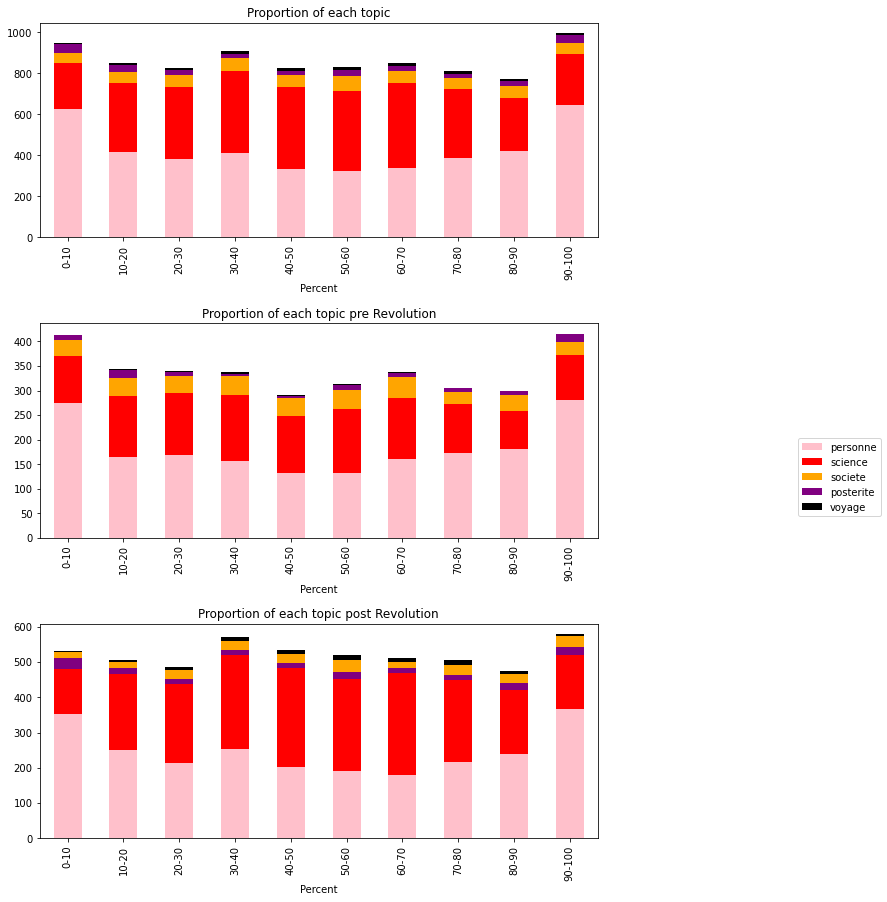

In [103]:
test,_,_ = plot_stack_bar(df_sent_hh)

144it [00:00, 22864.16it/s]
78it [00:00, 20877.84it/s]
66it [00:00, 18061.20it/s]


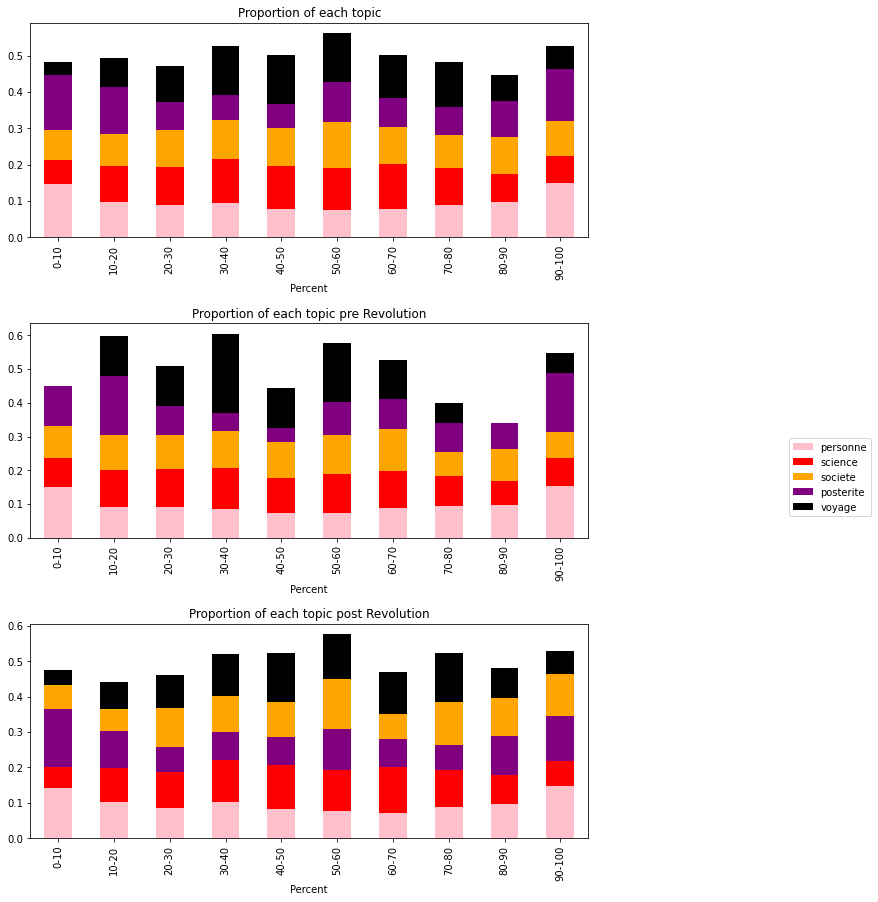

In [104]:
test,_,_ = plot_stack_bar(df_sent_hh, norm_by_tot=True)

No major differences

144it [00:00, 22619.27it/s]
78it [00:00, 20651.16it/s]
66it [00:00, 17647.84it/s]


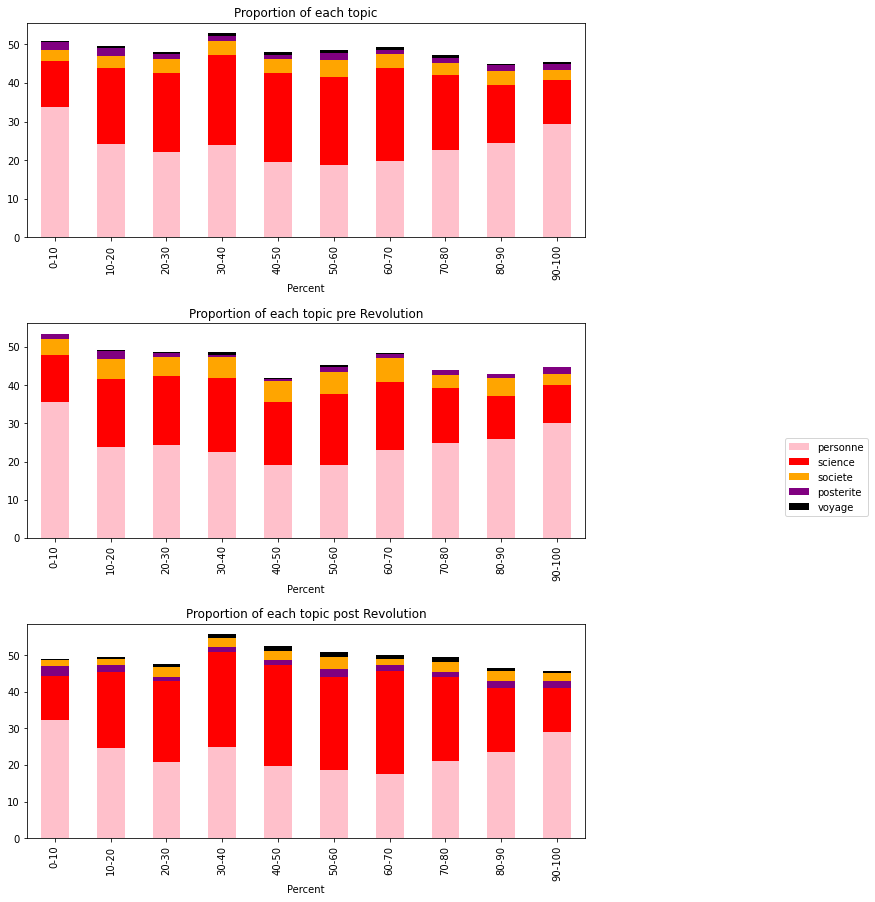

In [105]:
_,_,_ = plot_stack_bar(df_sent_hh, norm = True)

We speak more of politics before the Revolution, and more of travel after the Revolution

## By less higher topic

144it [00:00, 20052.45it/s]
78it [00:00, 19140.87it/s]
66it [00:00, 18196.55it/s]


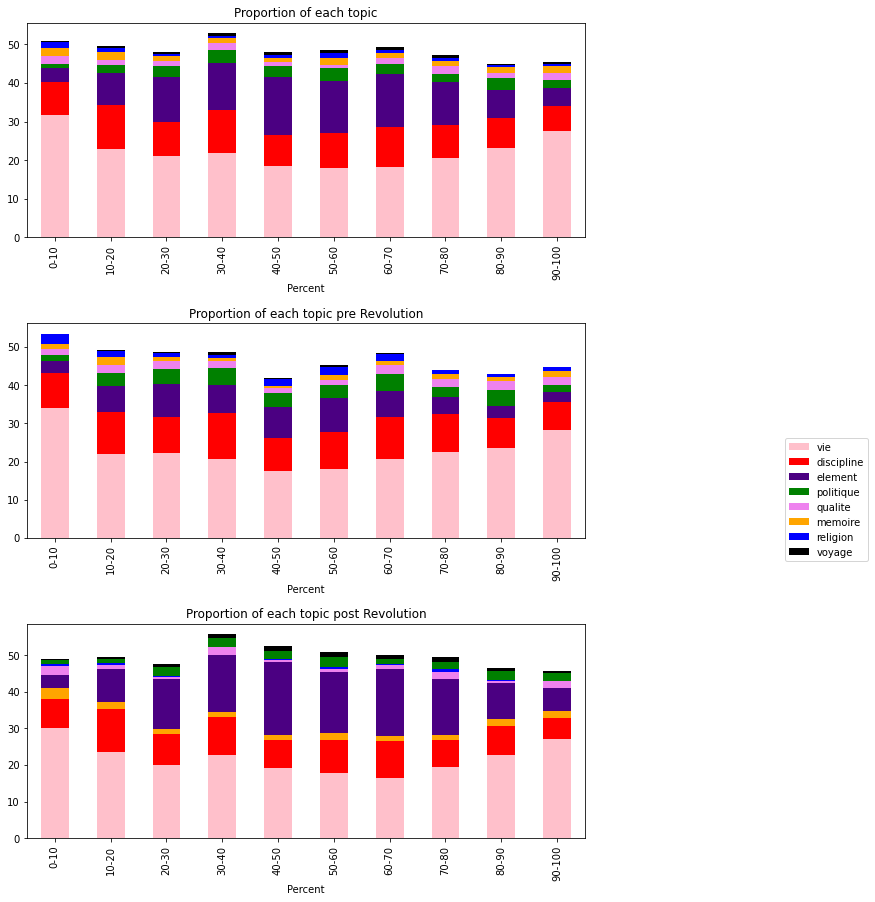

In [106]:
color_p = {'outlier' : 'grey', 'vie' : 'pink', 'qualite' : 'violet', 'discipline':
                                       'red', 'element' : 'indigo', 'memoire' : 'orange', 'politique' : 'green',
                                       'religion' : 'blue', 'voyage' : 'black'}
_,_,_=plot_stack_bar(df_sent_h, color_plot = color_p, norm = True, keep_outliers = False)

## Personne

In [107]:
df_vie = df_sent_t.copy()
df_vie['Topic_Ordered'] = df_vie['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_vie])

144it [00:00, 24514.16it/s]
78it [00:00, 23199.24it/s]
66it [00:00, 19998.85it/s]


KeyError: '1_card_naître_année_société'

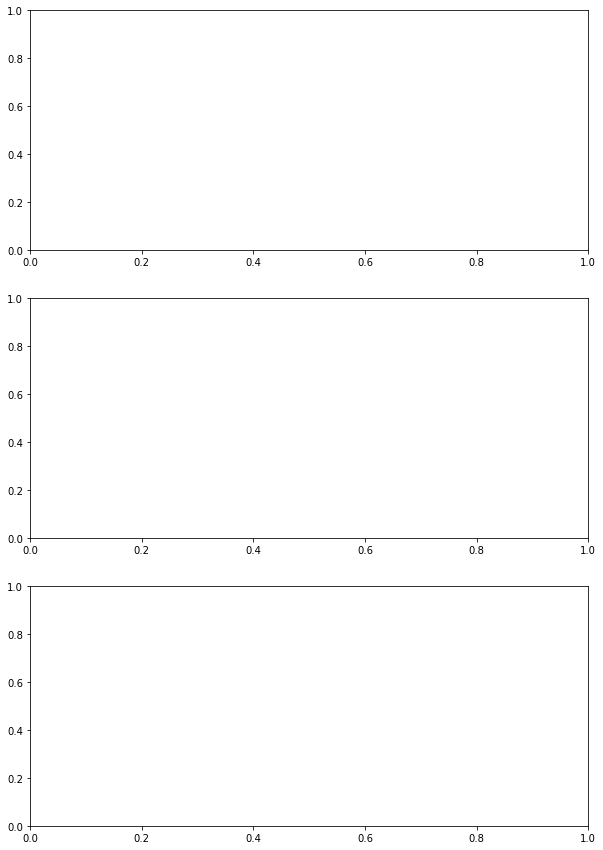

In [108]:
color_p = {'0_card_année_publier_mémoire' : 'grey', '3_fil_père_fils_famille' : 'green', '17_travail_temps_moment_carrière' :
          'orange', '29_homme_intérêt_amour_savoir' : 'pink', '31_naître_société_médeciner_institut' : 'purple',
          '20_professeur_école_élève_collège' : 'yellow', '32_jeunesse_enfant_âge_éducation' : 'red',
          '24_année_vie_travail_consacrer' : 'cyan', '41_été_ami_adresse_pallas' : 'indigo',
          '30_moi_mois_durer_passer' : 'black'}

_,_,_= plot_stack_bar(df_vie, keep_outliers = True, color_plot = color_p, norm = True)

On parle plus de la famille pre-revolution

## Jeunesse & mort

144it [00:00, 7275.20it/s]
78it [00:00, 3434.16it/s]
66it [00:00, 3780.92it/s]


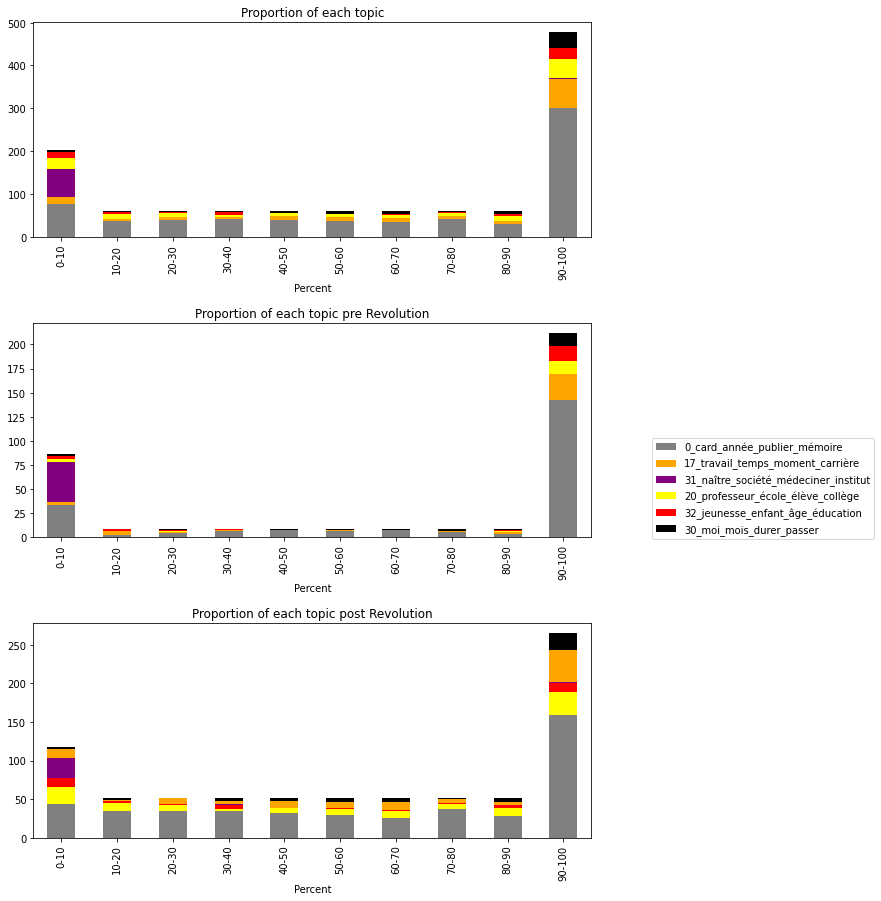

In [256]:
df_debut_fin = df_sent_t.copy()
df_debut_fin['Topic_Ordered'] = df_debut_fin['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in 
                                                                               [0, 17, 31, 20, 32, 30]])
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm = False)

144it [00:00, 5224.20it/s]
78it [00:00, 2126.97it/s]
66it [00:00, 2543.82it/s]


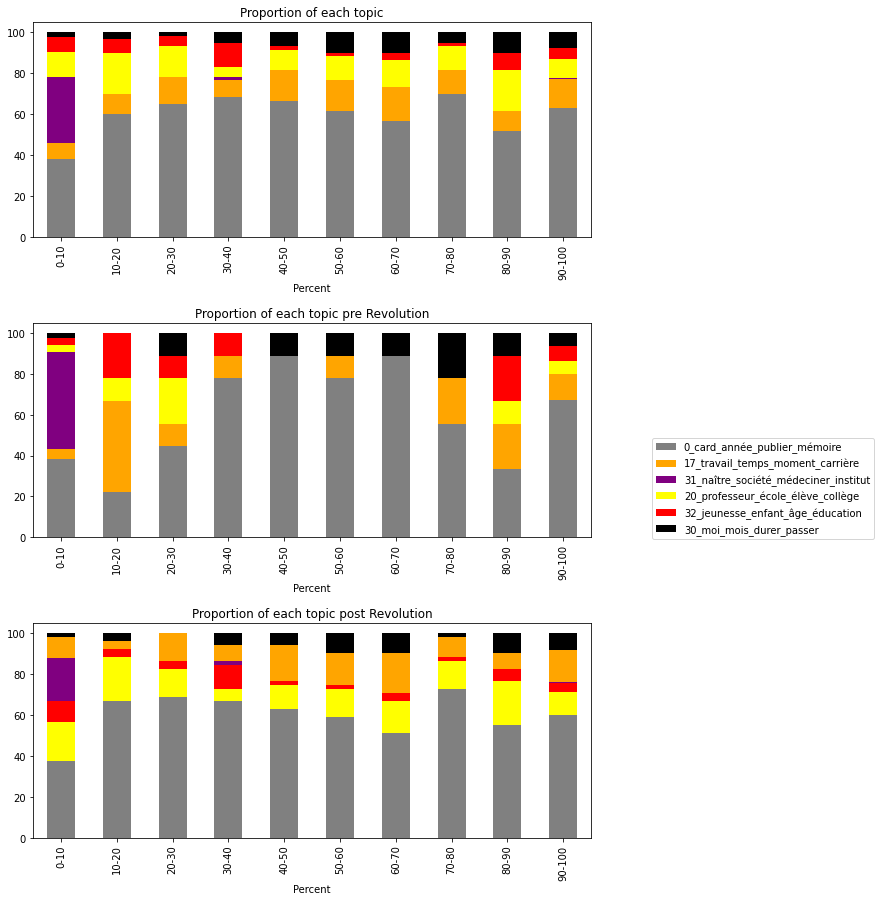

In [258]:
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm = True)

Professeur plus évoqué tout le long de la vie après révolution et la jeunesse aussi

144it [00:00, 6033.40it/s]
78it [00:00, 5444.25it/s]
66it [00:00, 2460.02it/s]


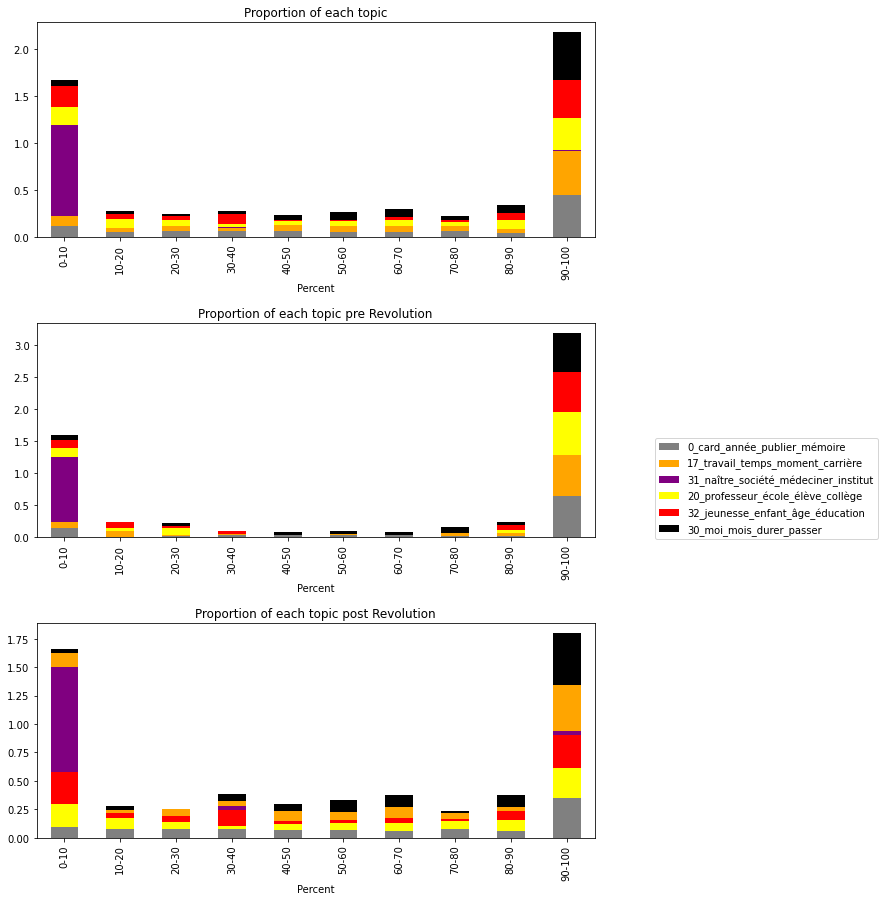

In [259]:
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm_by_tot = True)

card, année publier mémoire évoqué tout le long de l'éloge après éa révolution tout comme progresseur et travail temps
Ce qui concerne la jeunesse semble plus réparti

## Relations

144it [00:00, 5140.12it/s]
78it [00:00, 4469.46it/s]
66it [00:00, 4848.65it/s]


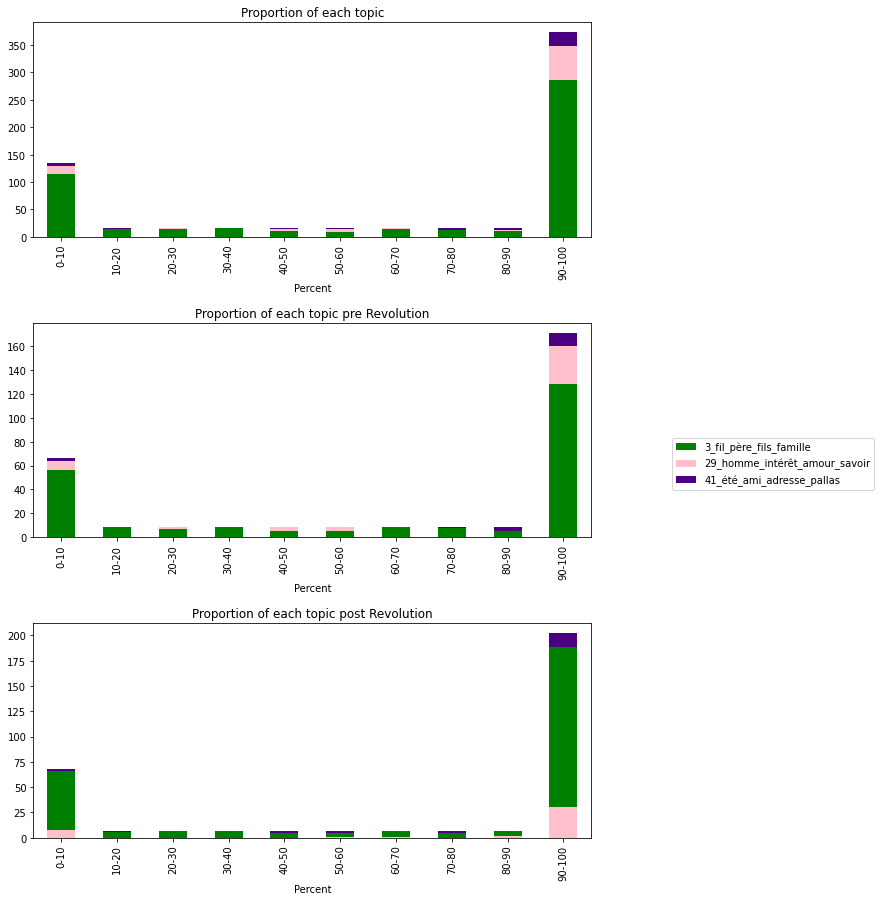

In [260]:
df_rel = df_sent_t.copy()
df_rel['Topic_Ordered'] = df_rel['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in [3,29,41]])

_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm = False)

144it [00:00, 7598.47it/s]
78it [00:00, 5345.77it/s]
66it [00:00, 1711.30it/s]


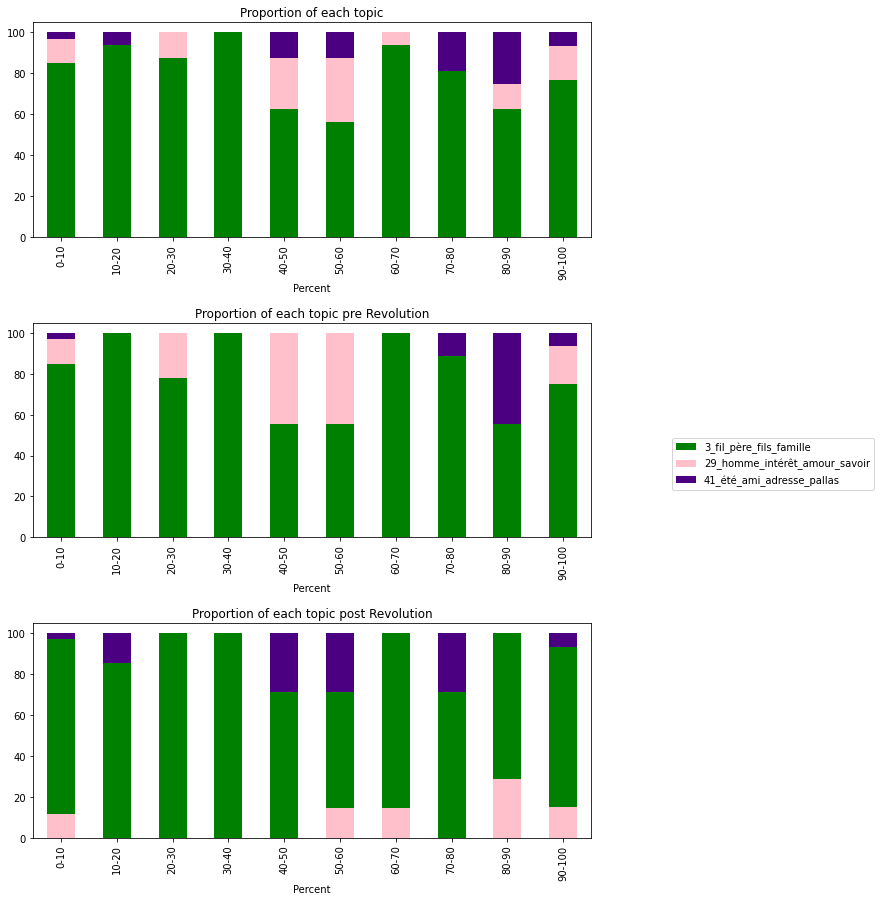

In [262]:

_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm = True)

Amis plus évoqués après la révolution dans l'éloge

144it [00:00, 7553.90it/s]
78it [00:00, 5286.68it/s]
66it [00:00, 4019.05it/s]


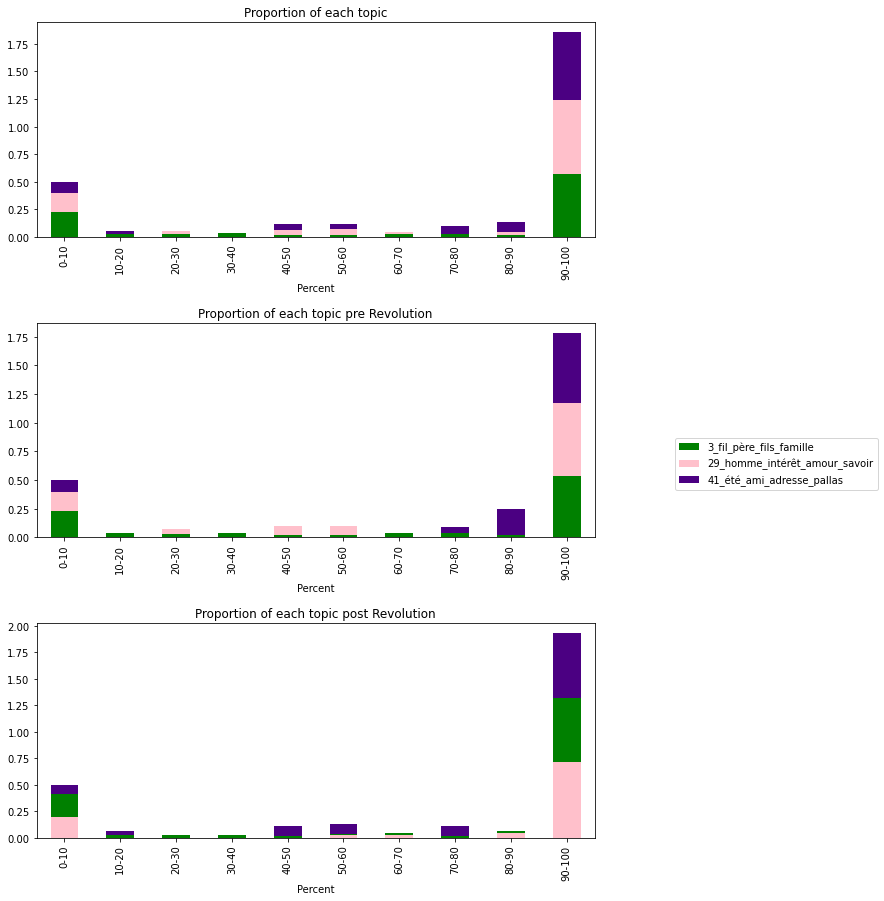

In [263]:
_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm_by_tot = True)

Ami semble être à l'inverse de amour savoir

## Politique & Religion

In [264]:
df_pol = df_sent_t.copy()
df_pol['Topic_Ordered'] = df_pol['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_societe])

144it [00:00, 7534.96it/s]
78it [00:00, 4988.80it/s]
66it [00:00, 2742.92it/s]


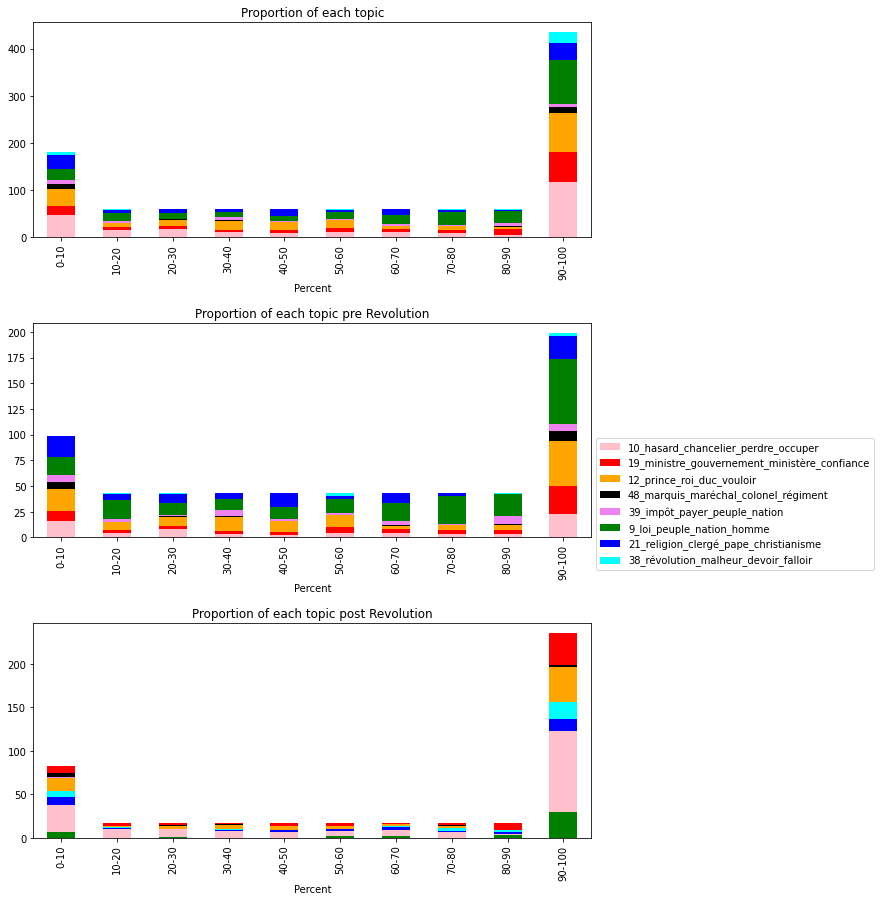

In [266]:
color_p = {'10_hasard_chancelier_perdre_occuper' : 'pink', '19_ministre_gouvernement_ministère_confiance' : 'red',
          '12_prince_roi_duc_vouloir' : 'orange', '48_marquis_maréchal_colonel_régiment' : 'black',
          '21_religion_clergé_pape_christianisme' : 'blue', '9_loi_peuple_nation_homme' : 'green',
          '39_impôt_payer_peuple_nation' : 'violet', '38_révolution_malheur_devoir_falloir' : 'cyan'}

_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = False)

Politique plus évoquée tout le long de l'éloge avant la révolution, particulièrement loi peuple nation pas hasard chancelier occuper perdre

144it [00:00, 7252.22it/s]
78it [00:00, 4378.83it/s]
66it [00:00, 2486.63it/s]


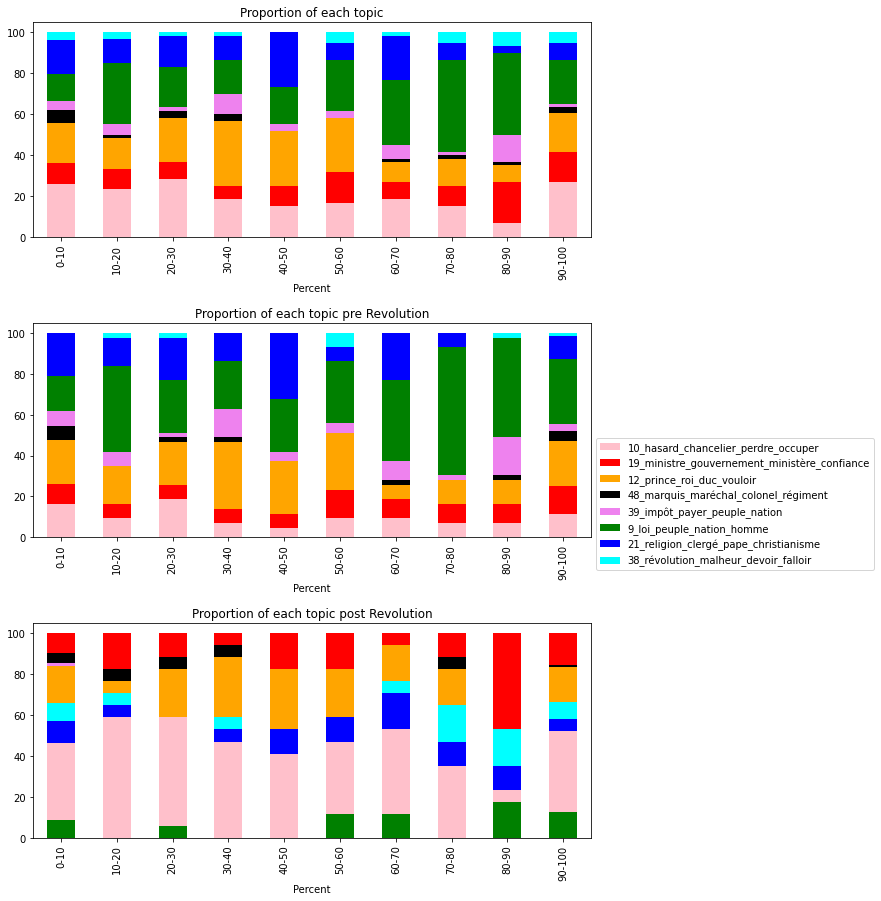

In [267]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = True)

Les deux sujets les plus importants post rev sont hasard chancelier perdre occuper et ministre ainsi que roi

Plus réparti avant la révolution

Religion a une part plus improtante avant la révolution

144it [00:00, 7595.41it/s]
78it [00:00, 3245.27it/s]
66it [00:00, 2772.62it/s]


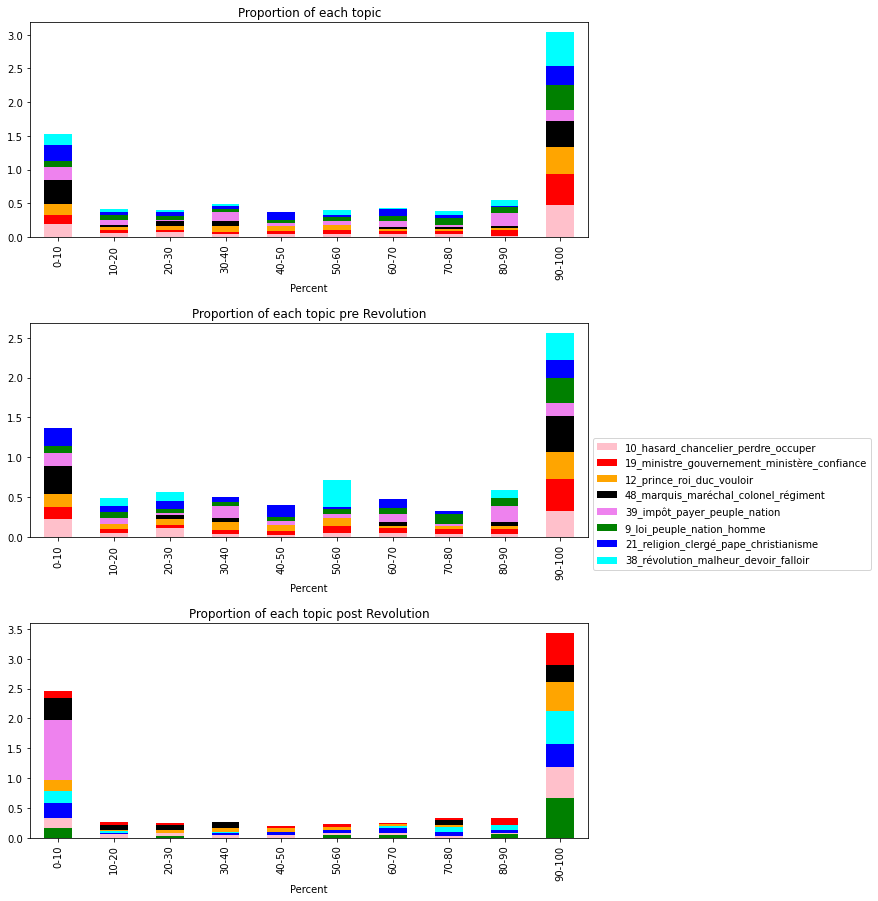

In [268]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Posterite

In [269]:
df_pos = df_sent_t.copy()
df_pos['Topic_Ordered'] = df_pos['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_posterite])

144it [00:00, 7784.15it/s]
78it [00:00, 3347.20it/s]
66it [00:00, 4115.24it/s]


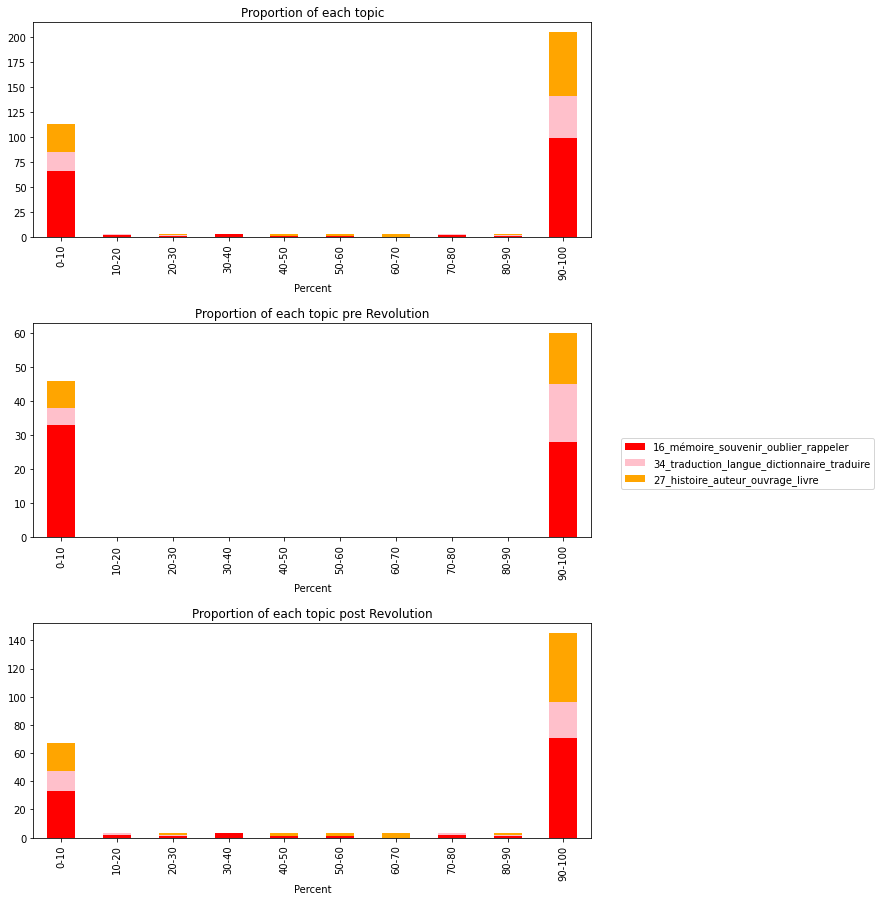

In [270]:
color_p = {'16_mémoire_souvenir_oublier_rappeler' : 'red', '34_traduction_langue_dictionnaire_traduire' : 'pink',
         '27_histoire_auteur_ouvrage_livre' : 'orange'}

_,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p)

Postérité beaucoup plus présente dans l'éloge après la Révolution

144it [00:00, 5355.76it/s]
78it [00:00, 4468.67it/s]
66it [00:00, 5511.02it/s]


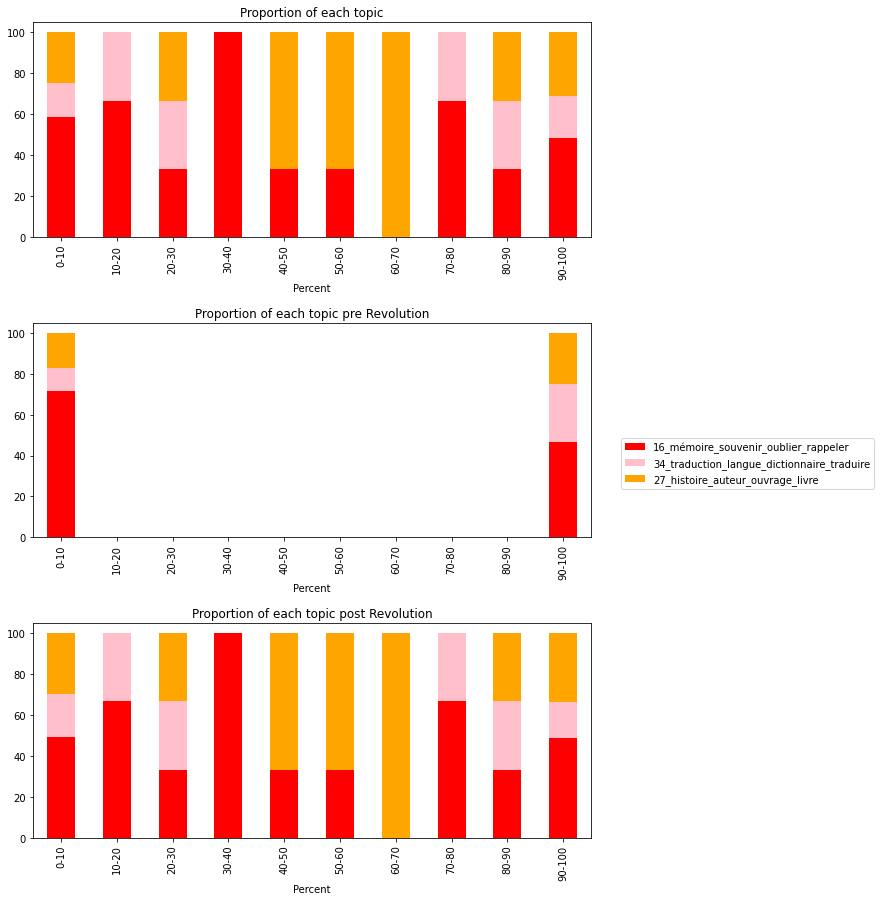

In [271]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm = True)

Avant la révolution postérité discutée qu'au début et à la fin de l'éloge par rapport à après la Révolution

144it [00:00, 6878.73it/s]
78it [00:00, 5630.13it/s]
66it [00:00, 2385.35it/s]


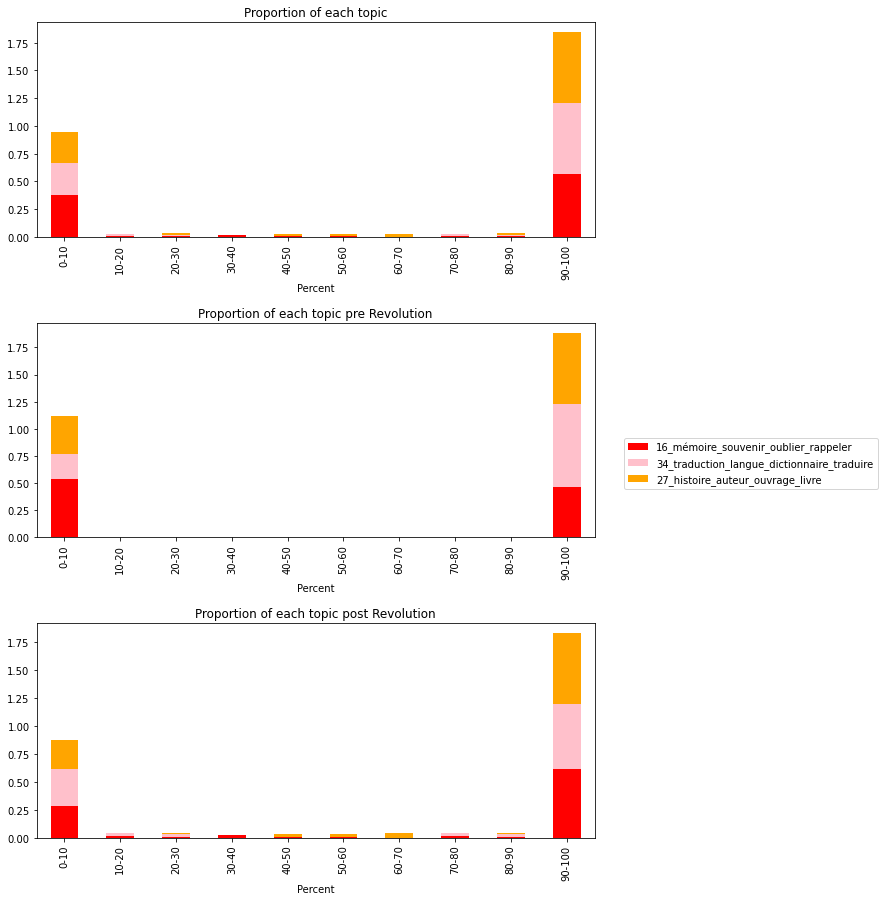

In [272]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Science

In [273]:
df_disc = df_sent_t.copy()
df_disc['Topic_Ordered'] = df_disc['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_discipline])

144it [00:00, 7375.59it/s]
78it [00:00, 4994.21it/s]
66it [00:00, 4246.55it/s]


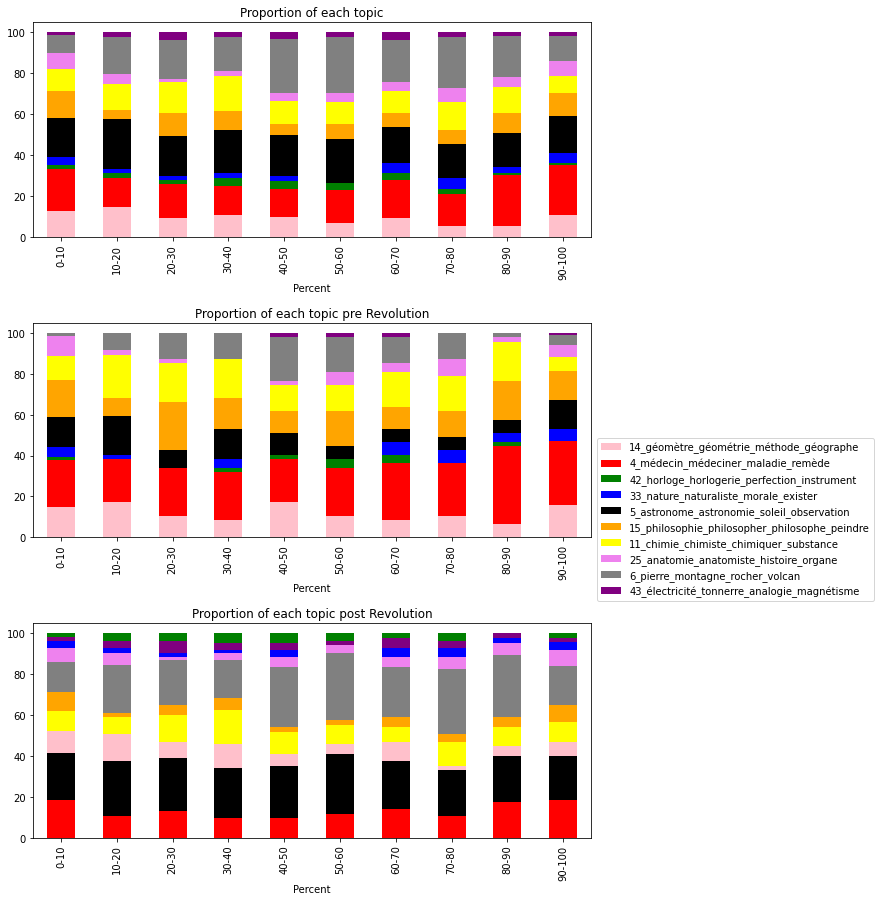

In [274]:
color_p = {'14_géomètre_géométrie_méthode_géographe'  : 'pink', '4_médecin_médeciner_maladie_remède' : 'red', 
          '42_horloge_horlogerie_perfection_instrument' : 'green', '33_nature_naturaliste_morale_exister' : 'blue',
          '5_astronome_astronomie_soleil_observation' : 'black', '15_philosophie_philosopher_philosophe_peindre' :
          'orange', '25_anatomie_anatomiste_histoire_organe' : 'violet', '6_pierre_montagne_rocher_volcan' :
          'grey', '11_chimie_chimiste_chimiquer_substance' : 'yellow', '43_électricité_tonnerre_analogie_magnétisme' :
          'purple'}

#, '26_anatomie_anatomiste_histoire_comparer' : 'cyan', '13_pierre_montagne_rocher_volcan' :
#          'magenta', '18_rayon_lumière_rayer_raire' : 'brown', '27_esprit_âme_penser_idée' : 'beige',
 #         '23_expérience_confirmer_répéter_tenter' : 'gold', '2_planter_plante_espèce_jardin' : 'silver'
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

144it [00:00, 5034.09it/s]
78it [00:00, 5185.21it/s]
66it [00:00, 1967.62it/s]


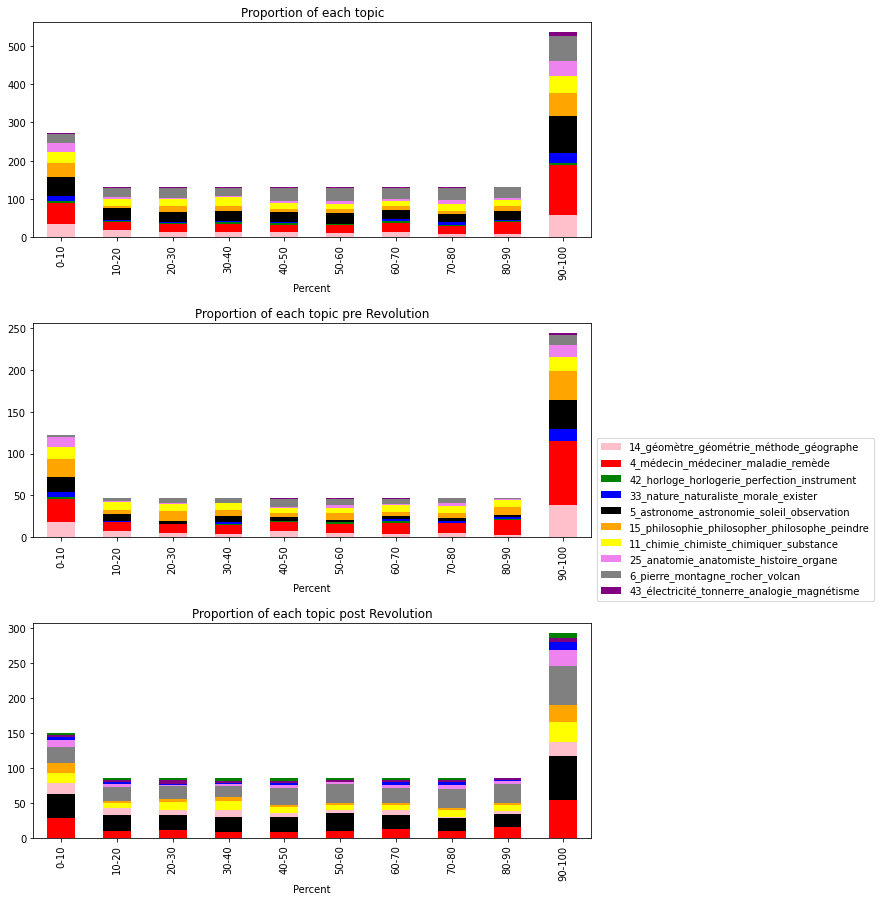

In [194]:
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

On parle plus de science dans le milieu du texte

On parle plus de l'art du dessin et de la peinture et philo en proportion

## Element

In [195]:
df_elem = df_sent_t.copy()
df_elem['Topic_Ordered'] = df_elem['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_element])

144it [00:00, 7473.42it/s]
78it [00:00, 4532.56it/s]
66it [00:00, 3819.90it/s]


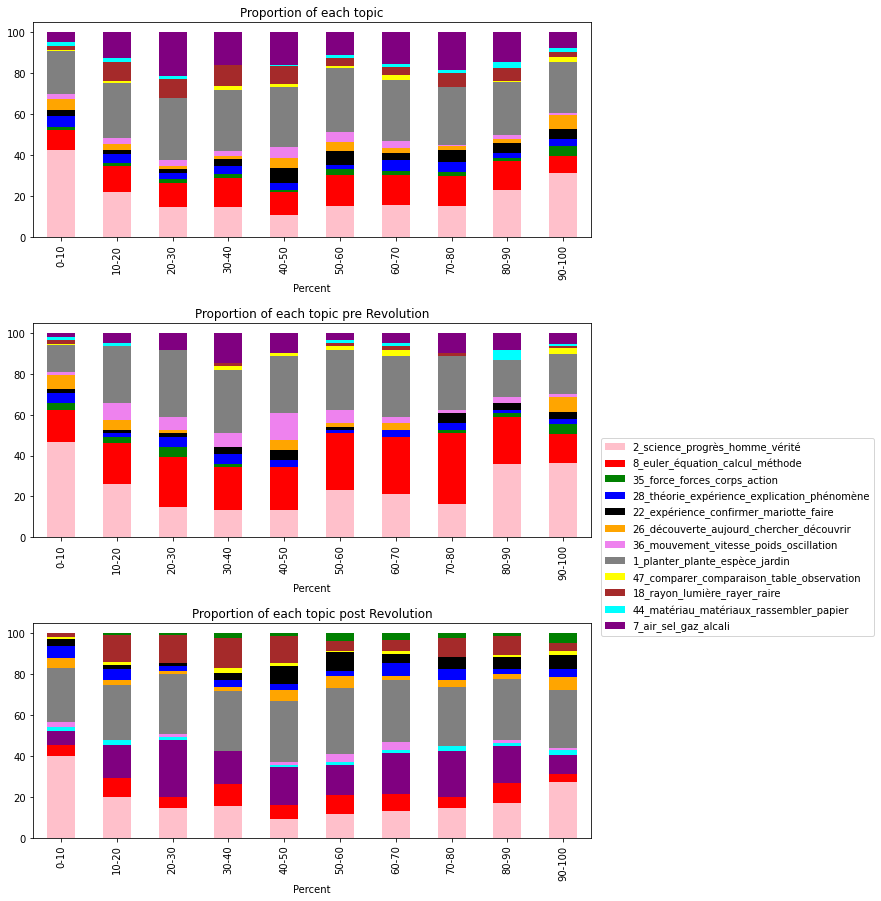

In [210]:
color_p = {'2_science_progrès_homme_vérité'  : 'pink', '8_euler_équation_calcul_méthode' : 'red', 
          '35_force_forces_corps_action' : 'green', '28_théorie_expérience_explication_phénomène' : 'blue',
          '22_expérience_confirmer_mariotte_faire' : 'black', '26_découverte_aujourd_chercher_découvrir' :
          'orange', '36_mouvement_vitesse_poids_oscillation' : 'violet', '1_planter_plante_espèce_jardin' :
          'grey', '47_comparer_comparaison_table_observation': 'yellow', '7_air_sel_gaz_alcali' :
          'purple', '44_matériau_matériaux_rassembler_papier' :
          'cyan', '18_rayon_lumière_rayer_raire' : 'brown'}#, '27_esprit_âme_penser_idée' : 'beige'}

perc,_,_ = plot_stack_bar(df_elem, keep_outliers = True, color_plot = color_p, norm = True)

144it [00:00, 4568.51it/s]
78it [00:00, 3779.26it/s]
66it [00:00, 4844.75it/s]


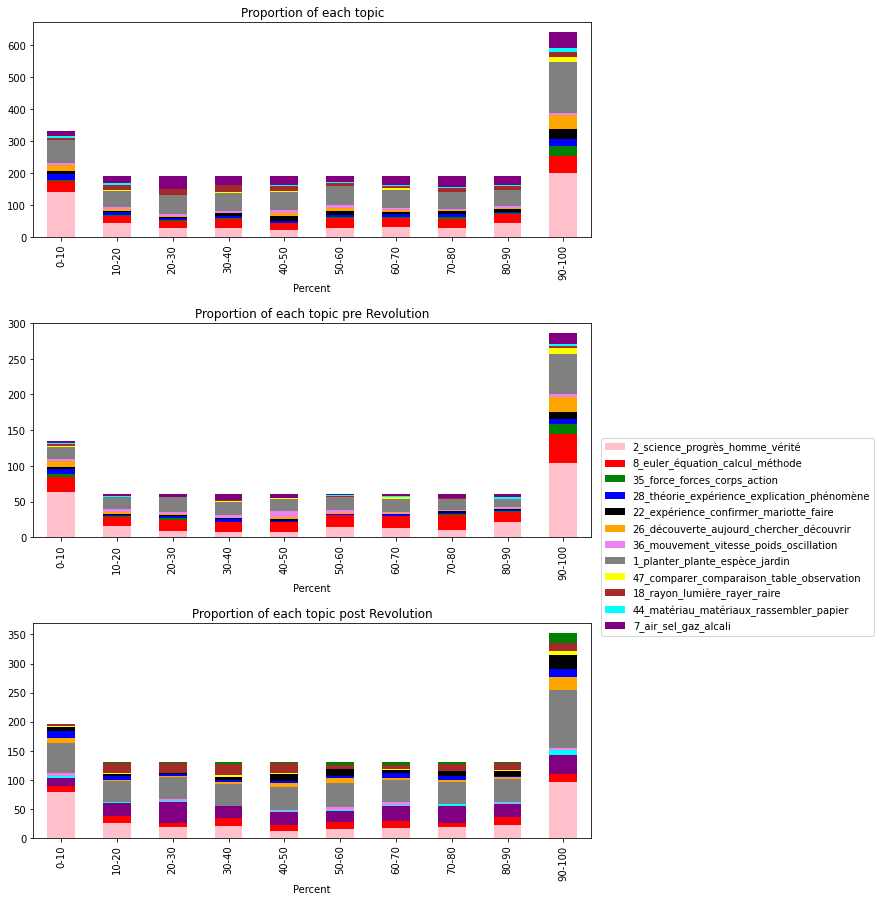

In [211]:
perc,_,_ = plot_stack_bar(df_elem, keep_outliers = True, color_plot = color_p)

## Voyage

144it [00:00, 7437.63it/s]
78it [00:00, 3662.16it/s]
66it [00:00, 3806.71it/s]


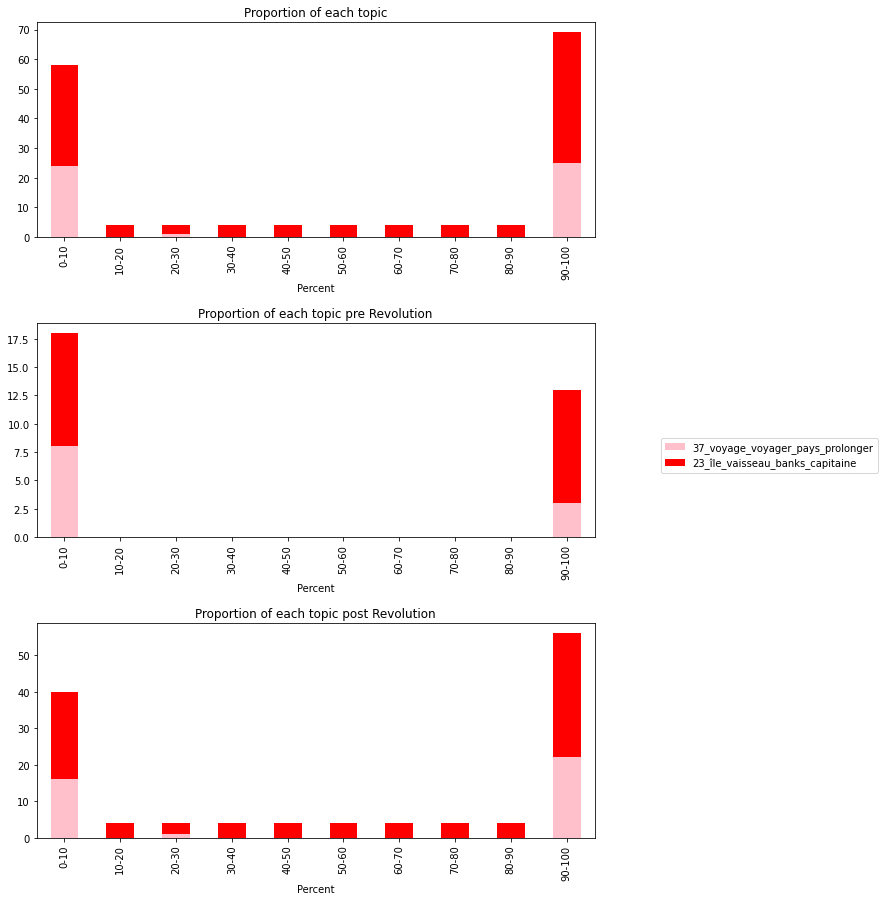

In [214]:
df_voy = df_sent_t.copy()
df_voy['Topic_Ordered'] = df_voy['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_voyage])

color_p = {'37_voyage_voyager_pays_prolonger'  : 'pink', '23_île_vaisseau_banks_capitaine' : 'red'}

perc,_,_ = plot_stack_bar(df_voy, keep_outliers = True, color_plot = color_p, norm = False)

# Assertivité

In [176]:
df_ass = pd.read_csv('./../../Data/Results/Adverbs.csv')


In [174]:
df_ass.fillna('default value', inplace =True)

In [177]:
df_ass[(df_ass['Assertivité']=='default value') & (df_ass['Temporalité']=='default value') &
      (df_ass['Expérience']=='default value')][['Adverb', 'Assertivité']]

Adverb    Assertivité
0                   plus  default value
1                     ne  default value
2                    pas  default value
3                      n  default value
4                 encore  default value
5                     si  default value
6                  moins  default value
8                  aussi  default value
9                   même  default value
10                   peu  default value
11                 point  default value
13                 comme  default value
14                  trop  default value
15                 alors  default value
17               presque  default value
19                 ainsi  default value
20                  tant  default value
22                  très  default value
24                 enfin  default value
25             cependant  default value
27                 assez  default value
28              beaucoup  default value
30                  rien  default value
31                   non  default value
33                  donc  default value
35                    là  default value
37             seulement  default value
38                autant  default value
39                  près  default value
41             également  default value
42               combien  default value
43                  loin  default value
44                   ici  default value
47                  lors  default value
50              ailleurs  default value
52               comment  default value
53                   que  default value
57                auprès  default value
59              personne  default value
60                    ci  default value
61                 guère  default value
62             davantage  default value
65              audessus  default value
66              aisément  default value
71            précisment  default value
73                autour  default value
76              vivement  default value
78                    qu  default value
79            uniquement  default value
80              pourquoi  default value
84        nécessairement  default value
86              pourtant  default value
87             autrement  default value
88             toutefois  default value
89             cestàdire  default value
90              purement  default value
91                  cher  default value
92      particulièrement  default value
94            reellement  default value
97                 voilà  default value
100            fortement  default value
101             ensemble  default value
102            audessous  default value
105           facilement  default value
109               audelà  default value
110            tellement  default value
111            néanmoins  default value
112          directement  default value
114       rigoureusement  default value
115                   où  default value
117            hautement  default value
120         profondément  default value
122                 delà  default value
124         publiquement  default value
125       tranquillement  default value
126           proprement  default value
127                outre  default value
128        exclusivement  default value
129            vainement  default value
130        ordinairement  default value
131        difficilement  default value
133           volontiers  default value
134         mutuellement  default value
136           simplement  default value
137           séparément  default value
138         sérieusement  default value
141        soigneusement  default value
142          puissamment  default value
143       singulièrement  default value
144       réciproquement  default value
149                voici  default value
152                  bas  default value
153         relativement  default value
159          diversement  default value
160          extrêmement  default value
166       indépendamment  default value
168         spécialement  default value
173           éminemment  default value
177            librement  default value
179               

In [178]:
df_ass[(df_ass['Assertivité']=='default value') & (df_ass['Temporalité']=='default value') &
      (df_ass['Expérience']=='default value')][['Adverb', 'Assertivité']].shape

(140, 2)

In [161]:
df_ass[df_ass['Assertivité']!='default value'][['Adverb', 'Assertivité']]

Adverb Assertivité
12            toujours     certain
16              jamais     certain
18                tout        tout
21             souvent     presque
23           peut-être      moitié
29             surtout     certain
40         quelquefois         peu
48              plutôt     presque
49             partout     certain
55         entièrement        tout
67          absolument     certain
70       naturellement     certain
75            vraiment     presque
77      principalement     presque
93        probablement     presque
95          exactement     certain
103       généralement     presque
113      véritablement     certain
119       certainement     certain
123    essentiellement     presque
139          justement     certain
140           sûrement     presque
145        apparemment     presque
146            environ     presque
147         totalement        tout
154         clairement     certain
155         assurément     certain
164             guères     presque
167       complètement        tout
169         évidemment     certain
170  incontestablement     certain
172        communément     presque
182        péniblement         peu
187         pleinement        tout
200          nullement     certain
205  vraisemblablement     presque
236    infailliblement     certain
254      effectivement     certain
255     inévitablement     certain

In [162]:
df_ass.to_csv('./../../Data/Results/Adverbs.csv')

In [148]:
df_ass[df_ass['Temporalité']!='default value'][['Adverb', 'Temporalité']]

Adverb Temporalité
12          toujours     eternel
16            jamais     éternel
21           souvent     presque
26         longtemps     presque
32              déjà  maintenant
34           bientôt     presque
40       quelquefois         peu
45        aujourdhui  maintenant
46           ensuite       suite
56    successivement       suite
58            tantôt       suite
63             après       suite
64          aussitôt         tot
68       constamment  maintenant
69          rarement         peu
72              tard        tard
81         autrefois       passe
82        maintenant  maintenant
85       promptement         tot
96     immédiatement  maintenant
98         désormais  maintenant
104       subitement         tot
106              tôt         tot
107  continuellement     eternel
108       rapidement         tot
116             puis       suite
118       auparavant       passe
121             vite         tot
132        récemment       passe
135       infiniment     eternel
150     anciennement       passe
151            jadis       passe
158     nouvellement         tot
165        lentement        tard
175       surlechamp         tot
178            sitôt         tot
183           depuis       suite
198     incessamment         tot
209    momentanément         tot
211     annuellement   fréquence
214    simultanément         tot
226          parfois         peu
228     expressément         tot
233     indéfiniment     eternel
235    graduellement   fréquence
236  infailliblement     eternel
238            avant       passe
239     régulirement   fréquence
243    éternellement     eternel
253   définitivement     eternel
255   inévitablement     eternel

In [143]:
df_ass[df_ass['Expérience']!='default value'][['Adverb', 'Expérience']]

Adverb Expérience
7               bien       plus
36             mieux       plus
51              fort       plus
54      heureusement       plus
74               mal      moins
83   malheureusement      moins
99      parfaitement       plus
220   convenablement       plus
223    généreusement       plus
224     imprudemment      moins
230       habilement       plus
231       fidèlement       plus
237     positivement       plus
240    favorablement       plus
242       violemment      moins
244  avantageusement       plus
246     conformément       plus
247     légitimement       plus
251        amèrement      moins

In [299]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet   1771   
1  Fontaine  Condorcet   1771   
2  Fontaine  Condorcet   1771   
3  Fontaine  Condorcet   1771   
4  Fontaine  Condorcet   1771   

                                               Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné...   
1   Il avait environ vingt ans lorsque son père m...   
2   Ses parents auraient voulu qu’il suivit les é...   
3   Né avec cette rigueur d’esprit que les démons...   
4   Tourmenté par les sollicitations de ses paren...   

                                               no_sw  \
0  Alexis Fontaine naquit Claveison Dauphiné, l’a...   
1                                    ans père mourut   
2  Ses parents voulu qu’il suivit études droit, n...   
3  rigueur d’esprit démonstrations satisfaire, do...   
4  Tourmenté sollicitations parents, l’activité g...   

                                      no_sw_no_punkt  \
0  Alexis Fontaine naquit Claveison Dauphiné  l a...   
1                                    ans père mourut   
2  Ses parents voulu qu il suivit études droit  n...   
3  rigueur d esprit démonstrations satisfaire  do...   
4  Tourmenté sollicitations parents  l activité g...   

                                                tags  \
0  [(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...   
1  [(ans, NOM, an), (père, NOM, père), (mourut, V...   
2  [(Ses, DET:POS, son), (parents, NOM, parents),...   
3  [(rigueur, NOM, rigueur), (d, VER:futu, d), (e...   
4  [(Tourmenté, VER:pper, tourmenter), (sollicita...   

                                           Eloge_lem  \
0  Alexis Fontaine naître Claveison Dauphiné l an...   
1                                     an père mourir   
2  son parents vouloir qu il suivre étude droit n...   
3  rigueur d esprit démonstration satisfaire donn...   
4  tourmenter sollicitation parent l activité gén...   

                                                 n_v  
0                                  naître année card  
1                                        père mourir  
2  vouloir étude exercer charge styler commentate...  
3  rigueur esprit démonstration satisfaire donner...  
4  tourmenter sollicitation activité génie provin...

In [194]:
adv = keep_adv(sent, 'Eloge_lem')

In [195]:
df_ass['Temp_Ass'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Temp_Exp'] = df_ass.apply(lambda row : 1 if ((row['Expérience']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Ass_Exp'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                 (row['Expérience']!='default value')) else 0,axis=1)

In [196]:
df_ass.head()

Unnamed: 0  Adverb  Number               Categorie    Assertivité  \
0           0    plus    5933                quantité  default value   
1           1      ne    5339                négation  default value   
2           2     pas    3139                négation  default value   
3           3       n    2310                négation  default value   
4           4  encore    1404  temps_quantité_logique  default value   

     Temporalité     Expérience  Temp_Ass  Temp_Exp  Ass_Exp  
0  default value  default value         0         0        0  
1  default value  default value         0         0        0  
2  default value  default value         0         0        0  
3  default value  default value         0         0        0  
4  default value  default value         0         0        0

In [197]:
ls_ass = df_ass[(df_ass['Assertivité']!='default value') & (df_ass['Temp_Ass']==0) &
                                                         (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp = df_ass[(df_ass['Temporalité']!='default value') & (df_ass['Temp_Ass']==0)
                & (df_ass['Temp_Exp']==0)]['Adverb'].tolist()
ls_exp = df_ass[(df_ass['Expérience']!='default value') & (df_ass['Temp_Exp']==0)
               & (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp_exp = df_ass[df_ass['Temp_Exp']==1]['Adverb'].tolist()
ls_ass_exp = df_ass[df_ass['Ass_Exp']==1]['Adverb'].tolist()
ls_temp_ass = df_ass[df_ass['Temp_Ass']==1]['Adverb'].tolist()

In [198]:
adv.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet   1771   
1  Fontaine  Condorcet   1771   
2  Fontaine  Condorcet   1771   
3  Fontaine  Condorcet   1771   
4  Fontaine  Condorcet   1771   

                                               Eloge  Wrong  \
0  Alexis Fontaine naquit à Claveison en Dauphiné...      0   
1   Il avait environ vingt ans lorsque son père m...      0   
2   Ses parents auraient voulu qu’il suivit les é...      0   
3   Né avec cette rigueur d’esprit que les démons...      0   
4   Tourmenté par les sollicitations de ses paren...      0   

                                               no_sw  \
0  Alexis Fontaine naquit Claveison Dauphiné, l’a...   
1                                    ans père mourut   
2  Ses parents voulu qu’il suivit études droit, n...   
3  rigueur d’esprit démonstrations satisfaire, do...   
4  Tourmenté sollicitations parents, l’activité g...   

                                      no_sw_no_punkt  \
0  Alexis Fontaine naquit Claveison Dauphiné  l a...   
1                                    ans père mourut   
2  Ses parents voulu qu il suivit études droit  n...   
3  rigueur d esprit démonstrations satisfaire  do...   
4  Tourmenté sollicitations parents  l activité g...   

                                                tags  \
0  [(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...   
1  [(ans, NOM, an), (père, NOM, père), (mourut, V...   
2  [(Ses, DET:POS, son), (parents, NOM, parents),...   
3  [(rigueur, NOM, rigueur), (d, VER:futu, d), (e...   
4  [(Tourmenté, VER:pper, tourmenter), (sollicita...   

                                           Eloge_lem  \
0  Alexis Fontaine naître Claveison Dauphiné l an...   
1                                     an père mourir   
2  son parents vouloir qu il suivre étude droit n...   
3  rigueur d esprit démonstration satisfaire donn...   
4  tourmenter sollicitation parent l activité gén...   

                                                 n_v  \
0                                  naître année card   
1                                        père mourir   
2  vouloir étude exercer charge styler commentate...   
3  rigueur esprit démonstration satisfaire donner...   
4  tourmenter sollicitation activité génie provin...   

                            adverbs  
0                                []  
1                                []  
2                                []  
3  [ailleurs, guère, bien, souvent]  
4                                []

In [207]:
plot_adv = adv.copy()
plot_adv = plot_adv[['Savant', 'Auteur', 'Annee', 'Eloge', 'adverbs']]
plot_adv['Assertivité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass]))
plot_adv['Temporalité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp]))
plot_adv['Expérience'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_exp]))
plot_adv['Temp_Ass'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_ass]))
plot_adv['Temp_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_exp]))
plot_adv['Ass_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass_exp]))
plot_adv['Else'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if (elem not in ls_ass
                                                                                   and elem not in ls_temp
                                                                                   and elem not in ls_exp
                                                                                   and elem not in ls_ass
                                                                                   and elem not in ls_temp_ass
                                                                                   and elem not in ls_ass_exp
                                                                                   and elem not in ls_temp_exp)]))

In [208]:
plot_adv = plot_adv.groupby(['Annee']).agg({'Assertivité' : 'sum', 'Temporalité' : 'sum', 'Expérience' :
                                           'sum', 'Temp_Ass' : 'sum', 'Ass_Exp' : 'sum', 'Temp_Exp' : 'sum',
                                           'Else' : 'sum'})

<AxesSubplot:xlabel='Annee'>

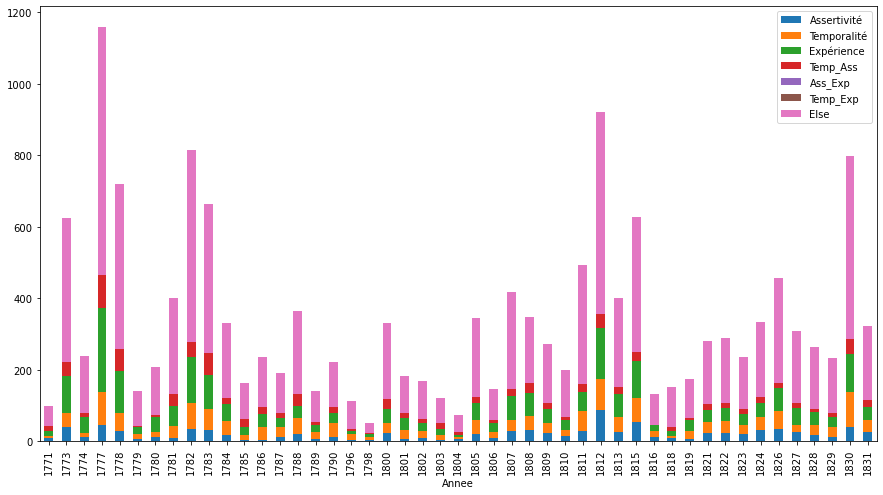

In [209]:
plot_adv.plot.bar(stacked = True, figsize = (15,8))

In [212]:
plot_adv['All'] = plot_adv.sum(axis=1)
plot_adv['Assertivité'] = plot_adv.apply(lambda row : row['Assertivité']/row['All'],axis=1)
plot_adv['Temporalité'] = plot_adv.apply(lambda row : row['Temporalité']/row['All'],axis=1)
plot_adv['Expérience'] = plot_adv.apply(lambda row : row['Expérience']/row['All'],axis=1)
plot_adv['Temp_Ass'] = plot_adv.apply(lambda row : row['Temp_Ass']/row['All'],axis=1)
plot_adv['Temp_Exp'] = plot_adv.apply(lambda row : row['Temp_Exp']/row['All'],axis=1)
plot_adv['Ass_Exp'] = plot_adv.apply(lambda row : row['Ass_Exp']/row['All'],axis=1)

<AxesSubplot:xlabel='Annee'>

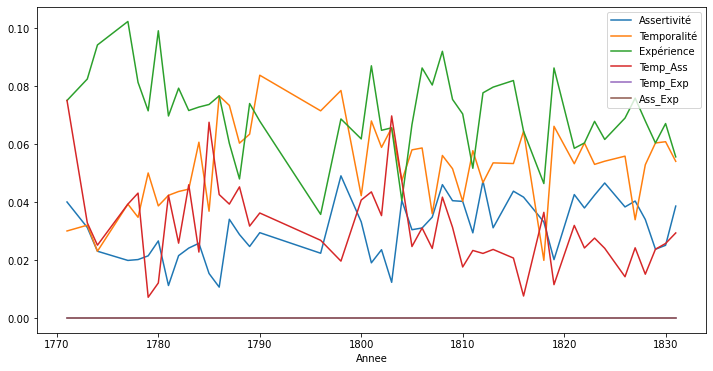

In [215]:
plot_adv[['Assertivité', 'Temporalité', 'Expérience', 'Temp_Ass', 'Temp_Exp', 'Ass_Exp']].plot(kind='line',
                                                                                              figsize = (12,6))

## Assertivity

In [224]:
ass = adv.copy()
ass = ass[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
ass['adverbs'] = ass['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_ass or elem in ls_temp_ass
                                                                        or elem in ls_ass_exp)])

ass['Catégorie'] = ass['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Assertivité'][0]
                                                   for elem in x])

In [225]:
ass.head()

Auteur  Annee    Savant  \
0  Condorcet   1771  Fontaine   
1  Condorcet   1771  Fontaine   
2  Condorcet   1771  Fontaine   
3  Condorcet   1771  Fontaine   
4  Condorcet   1771  Fontaine   

                                               Eloge    adverbs  Catégorie  
0  Alexis Fontaine naquit à Claveison en Dauphiné...         []         []  
1   Il avait environ vingt ans lorsque son père m...         []         []  
2   Ses parents auraient voulu qu’il suivit les é...         []         []  
3   Né avec cette rigueur d’esprit que les démons...  [souvent]  [presque]  
4   Tourmenté par les sollicitations de ses paren...         []         []

In [229]:
ls_cat = ass['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['presque', 'certain', 'tout', 'peu'], dtype=object)

In [234]:
for cat in ls_cat :
    ass[cat] = ass['Catégorie'].apply(lambda x : x.count(cat))
    
ass_plot = ass.groupby(['Annee'])[ls_cat].sum()

<AxesSubplot:xlabel='Annee'>

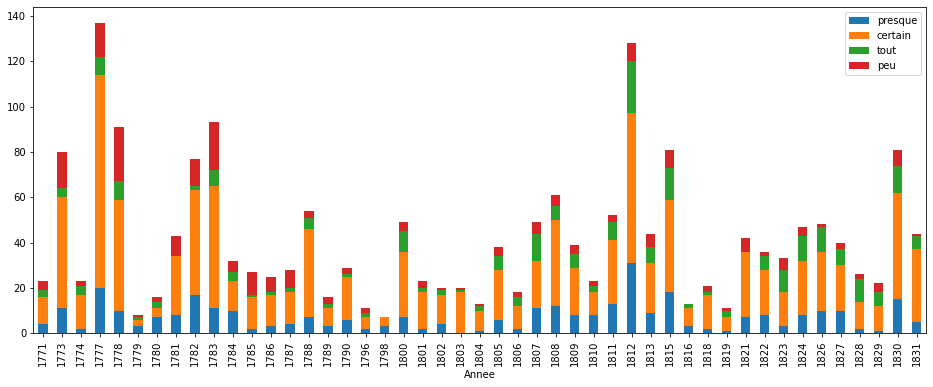

In [239]:
ass_plot.plot(kind='bar', stacked=True, figsize = (16,6))

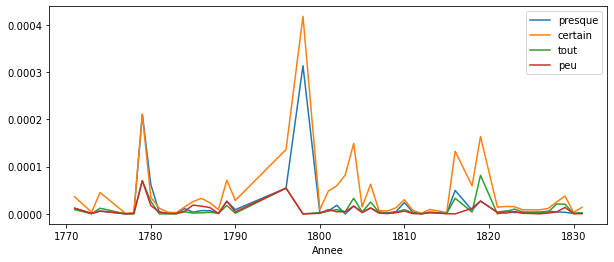

In [252]:
ass_plot['all'] = ass_plot.sum(axis=1)

for cat in ls_cat:
    ass_plot[cat] = ass_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    ass_plot[cat].plot(kind='line', figsize = (10,4), label=cat)
    
plt.legend()

## Temporality

In [253]:
temp = adv.copy()
temp = temp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
temp['adverbs'] = temp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_temp or elem in ls_temp_ass
                                                                        or elem in ls_temp_exp)])

temp['Catégorie'] = temp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Temporalité'][0]
                                                   for elem in x])

In [256]:
ls_cat = temp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['presque', 'peu', 'suite', 'éternel', 'maintenant', 'tard',
       'eternel', 'tot', 'passe', 'fréquence'], dtype=object)

In [258]:
for cat in ls_cat :
    temp[cat] = temp['Catégorie'].apply(lambda x : x.count(cat))
    
temp_plot = temp.groupby(['Annee'])[ls_cat].sum()

<AxesSubplot:xlabel='Annee'>

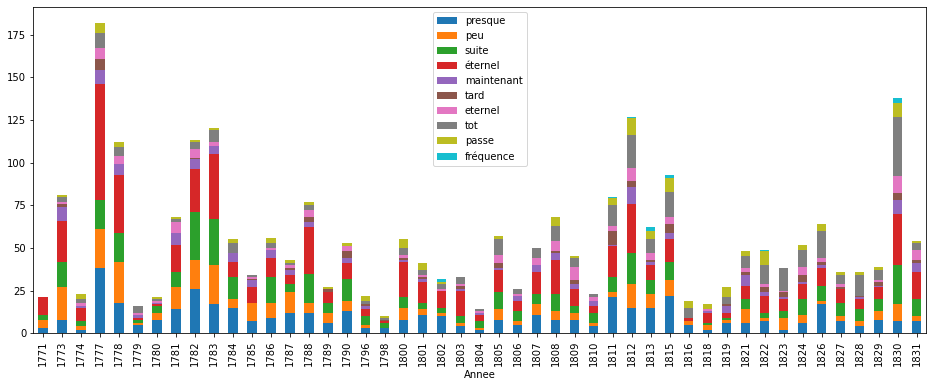

In [259]:
temp_plot.plot(kind='bar', stacked=True, figsize = (16,6))

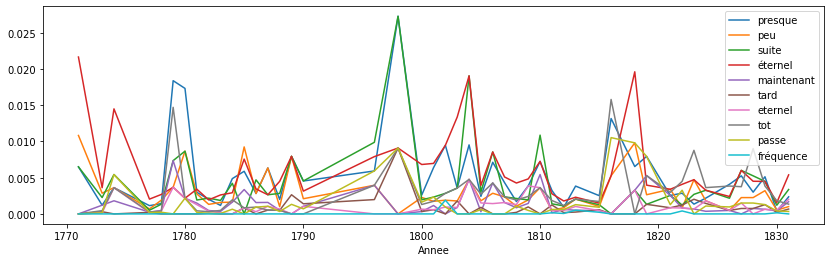

In [261]:
temp_plot['all'] = temp_plot.sum(axis=1)

for cat in ls_cat:
    temp_plot[cat] = temp_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    temp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    
plt.legend()

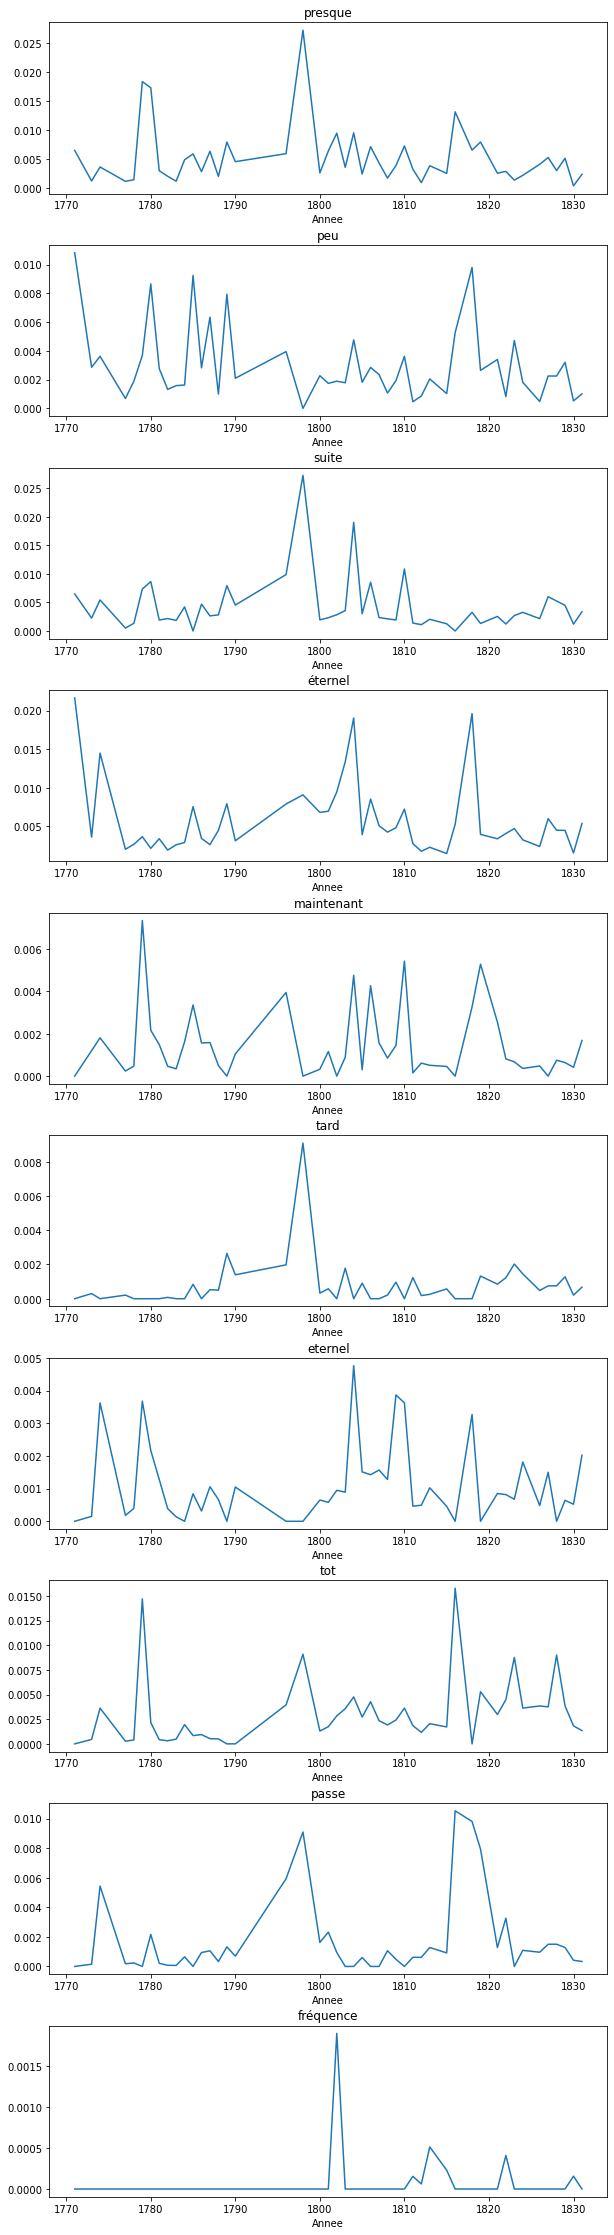

In [267]:
fig, ax = plt.subplots(nrows = ls_cat.size, ncols=1, figsize = (10, 4*ls_cat.size))

for idx, cat in enumerate(ls_cat):
    temp_plot[cat].plot(kind='line', title = cat, ax=ax[idx])
    
plt.subplots_adjust(hspace = 0.3)

## Experience

In [268]:
exp = adv.copy()
exp = exp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
exp['adverbs'] = exp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_exp or elem in ls_temp_exp
                                                                        or elem in ls_ass_exp)])

exp['Catégorie'] = exp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Expérience'][0]
                                                   for elem in x])

In [270]:
ls_cat = exp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['plus', 'moins'], dtype=object)

In [272]:
for cat in ls_cat :
    exp[cat] = exp['Catégorie'].apply(lambda x : x.count(cat))
    
exp_plot = exp.groupby(['Annee'])[ls_cat].sum()

<AxesSubplot:xlabel='Annee'>

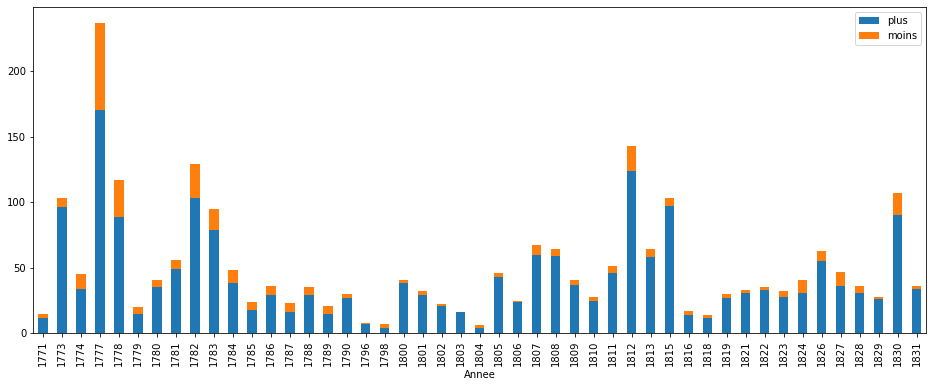

In [273]:
exp_plot.plot(kind='bar', stacked=True, figsize = (16,6))

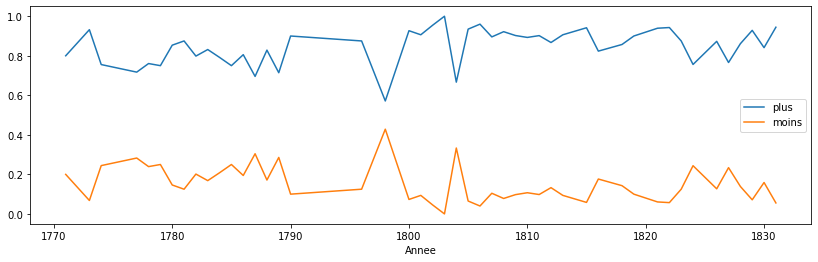

In [274]:
exp_plot['all'] = exp_plot.sum(axis=1)

for cat in ls_cat:
    exp_plot[cat] = exp_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    exp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    
plt.legend()